In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [22]:
import seaborn as sns
import matplotlib as mpl

# Theme and Font
sns.set_theme(style="whitegrid", context="talk", palette="deep")
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "figure.autolayout": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "STIXGeneral", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    # Sizes
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 12,
    # Lines / markers
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.8,
    # Axes / grid
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "grid.color": "#e6e6e6",
    "axes.edgecolor": "#333333",
    "axes.spines.top": False,
    "axes.spines.right": False,
    # Ticks
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    # Legend
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.fancybox": True,
    "legend.edgecolor": "#444444",
    # Color cycle
    # "axes.prop_cycle": mpl.cycler(color=sns.color_palette("colorblind").as_hex())
})

# 8 factor

In [23]:
def M_mat_8_factor(t, x, y, q0):
    # set delta = np.pi gives the original 5-factor retraction
    
    # 2x2 matrices in basis B
    psi0 = np.array([[q0,      1.0 - q0],
                     [q0,      1.0 - q0]], dtype=complex)
    
    H = np.array([[1.0, 0.0],
                  [0.0, 0.0]], dtype=complex)

    I2 = np.eye(2, dtype=complex)

    def E_P(theta, P):
        # For a projector P: exp(i theta P) = I + (e^{i theta}-1) P
        return I2 + (np.exp(1j * theta) - 1.0) * P

    def E_psi(theta): return E_P(theta, psi0)
    def E_H(theta):   return E_P(theta, H)
    
    angels = [t*y/2, np.pi/2, -t*x/2, -np.pi,
              t*x/2, -np.pi/2, -t*y/2, np.pi]
    M = (E_psi(t*y/2) @ E_H(np.pi/2) @ E_psi(-t*x/2) @ E_H(-np.pi) 
            @ E_psi(t*x/2) @ E_H(-np.pi/2) @ E_psi(-t*y/2) @ E_H(np.pi))

    return M, angels

# 5 factor (family)

In [24]:
def M_mat_5_family_factor(t, x, y, q0, delta=np.pi):
    # set delta = np.pi gives the original 5-factor retraction
    
    # 2x2 matrices in basis B
    psi0 = np.array([[q0,      1.0 - q0],
                     [q0,      1.0 - q0]], dtype=complex)
    
    H = np.array([[1.0, 0.0],
                  [0.0, 0.0]], dtype=complex)

    I2 = np.eye(2, dtype=complex)

    def E_P(theta, P):
        # For a projector P: exp(i theta P) = I + (e^{i theta}-1) P
        return I2 + (np.exp(1j * theta) - 1.0) * P

    def E_psi(theta): return E_P(theta, psi0)
    def E_H(theta):   return E_P(theta, H)

    A = np.arctan2(y, x)
    R = np.sqrt(x*x + y*y)
    a1, a2 = A + delta/2, A - delta/2
    b1, b2 = -0.5*R/(2*np.sin(delta/2)), 0.5*R/(2*np.sin(delta/2))
    
    angels = [a1, b1*t, a2 - a1,  b2*t, -a2]
    M = E_H(a1) @ E_psi(b1*t) @ E_H(a2 - a1) @ E_psi(b2*t) @ E_H(-a2)

    return M, angels

# 6 factor (family)

In [25]:
def M_mat_6_family_factor(t, x, y, q0, delta=np.pi):
    # set delta = np.pi gives the original 6-factor retraction
    
    # 2x2 matrices in basis B
    psi0 = np.array([[q0,      1.0 - q0],
                     [q0,      1.0 - q0]], dtype=complex)
    
    H = np.array([[1.0, 0.0],
                  [0.0, 0.0]], dtype=complex)

    I2 = np.eye(2, dtype=complex)

    def E_P(theta, P):
        # For a projector P: exp(i theta P) = I + (e^{i theta}-1) P
        return I2 + (np.exp(1j * theta) - 1.0) * P

    def E_psi(theta): return E_P(theta, psi0)
    def E_H(theta):   return E_P(theta, H)

    # angles
    half = 0.5 * delta
    s1 = np.sin(half)
    d1 = 1.0 - np.cos(half)  # = 1 - cos(δ/2)

    # guard singular choices
    eps = 1e-12
    if abs(s1) < eps or abs(d1) < eps:
        raise ValueError("delta too close to a singular value: avoid δ ≈ 0 (mod 2π).")

    # pulses (UN-normalized basis)
    b1 = -0.5 * ( x / s1 + y / d1 )
    b2 =  0.5 * ( x / s1 - y / d1 )
    b3 =  y / d1

    angels = [half, b1*t, -delta, b2*t, half, b3*t]
    M = E_H(half) @ E_psi(b1*t) @ E_H(-delta) @ E_psi(b2*t) @ E_H(half) @ E_psi(b3*t)

    # 6-factor product
    return M, angels


# helper

In [26]:
def update_xyzk_new(alpha, beta, x, y, t, q0, M_mat_fun):

    M, angels = M_mat_fun(t, x, y, q0)

    result = M @ np.array([[alpha], [beta]], dtype=complex)
    alpha1, beta1 = result[0, 0], result[1, 0]

    q1 = q0 * np.abs(alpha1)**2
    z1 = alpha1 * np.conj(beta1)

    x1 = np.real(z1) 
    y1 = np.imag(z1) 

    return complex(alpha1), complex(beta1), float(x1), float(y1), float(q1), M, angels

from scipy.optimize import differential_evolution

def argmax_t_for_q1_new(alpha, beta, x, y, q0, M_mat_fun,
                    t_bounds=(1e-6, 1.0), xatol=1e-9, maxiter=500):
    
    lo, hi = t_bounds

    def q1_of_t(t):
        # Use your provided updater exactly as-is
        _, _, _, _, q1, _, _ = update_xyzk_new(alpha, beta, x, y, t, q0, M_mat_fun)
        # Guard against numerical issues
        if not np.isfinite(q1):
            return np.nan
        return q1

    def objective(t):
        q1_val = q1_of_t(t)
        # Penalize NaNs/Infs so the solver avoids bad regions
        if not np.isfinite(q1_val):
            return np.inf
        return -q1_val


    res = differential_evolution(
        objective,
        bounds=[(lo, hi)]
    )

    # t_star = float(res.x)
    t_star = res.x
    q1_star = float(q1_of_t(t_star)) if res.success else np.nan

    return t_star, q1_star, res


# test

In [27]:
# --- config ---
n_values = list(range(2, 26))  # 2..30 inclusive
M = 1 # rank of H
T = 150000
tol = 1e-4

delta = np.pi  # default

def M_mat_5_family(t, x, y, q0):
    return M_mat_5_family_factor(t, x, y, q0, delta)

def M_mat_6_family(t, x, y, q0):
    return M_mat_6_family_factor(t, x, y, q0, delta)

M_mat = M_mat_5_family
# M_mat = M_mat_6_family
# M_mat = M_mat_8_factor

K_num_H = 2 # set 2 for 5-factor, 4 for 8-factor, 3 for 6-factor
    
def run_once(n, M_mat, M=1, T=60, tol=1e-4, step='fixed'):
    N = 2**n
    q0 =  M / N
    x, y = 1.0, 0.0
    alpha = 1.0 + 0j
    beta  = 1.0 + 0j
    q = q0
    q_list = [q0]
    angles_list = []
    
    t = 0
    while True:
        
        if step == 'fixed':
            # Lipschitz constant, only for 5-factor retraction
            L_Rie = 2 + N/ np.sqrt(2 * M * (N - M))
            t_k = 1/L_Rie
            # t_k = 0.1 * t_k
            
        else:
            # exact line search update    
            t_k, _, _ = argmax_t_for_q1_new(alpha, beta, x, y, q0, 
                                                M_mat,
                                                t_bounds=(-1e-6, np.pi*2+1e-6),
                                                )
        
        alpha, beta, x, y, q, _, angels = update_xyzk_new(alpha, beta, x, y, t_k, q0, M_mat)
        
        angles_list.append(angels)

        q_list.append(q)

        t += 1

        if abs(1 - q) < tol or len(q_list) >= T + 1: 
            break
        
    return np.array(q_list)


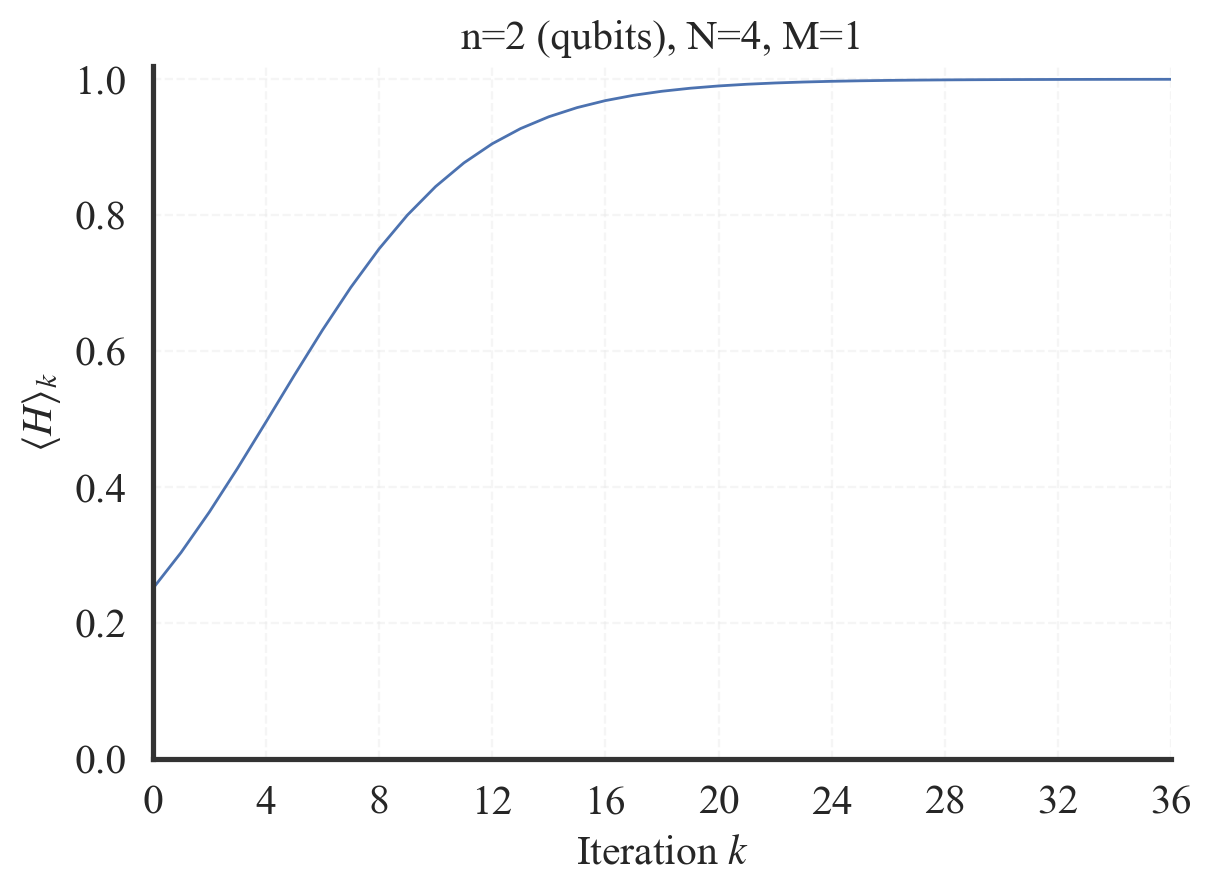

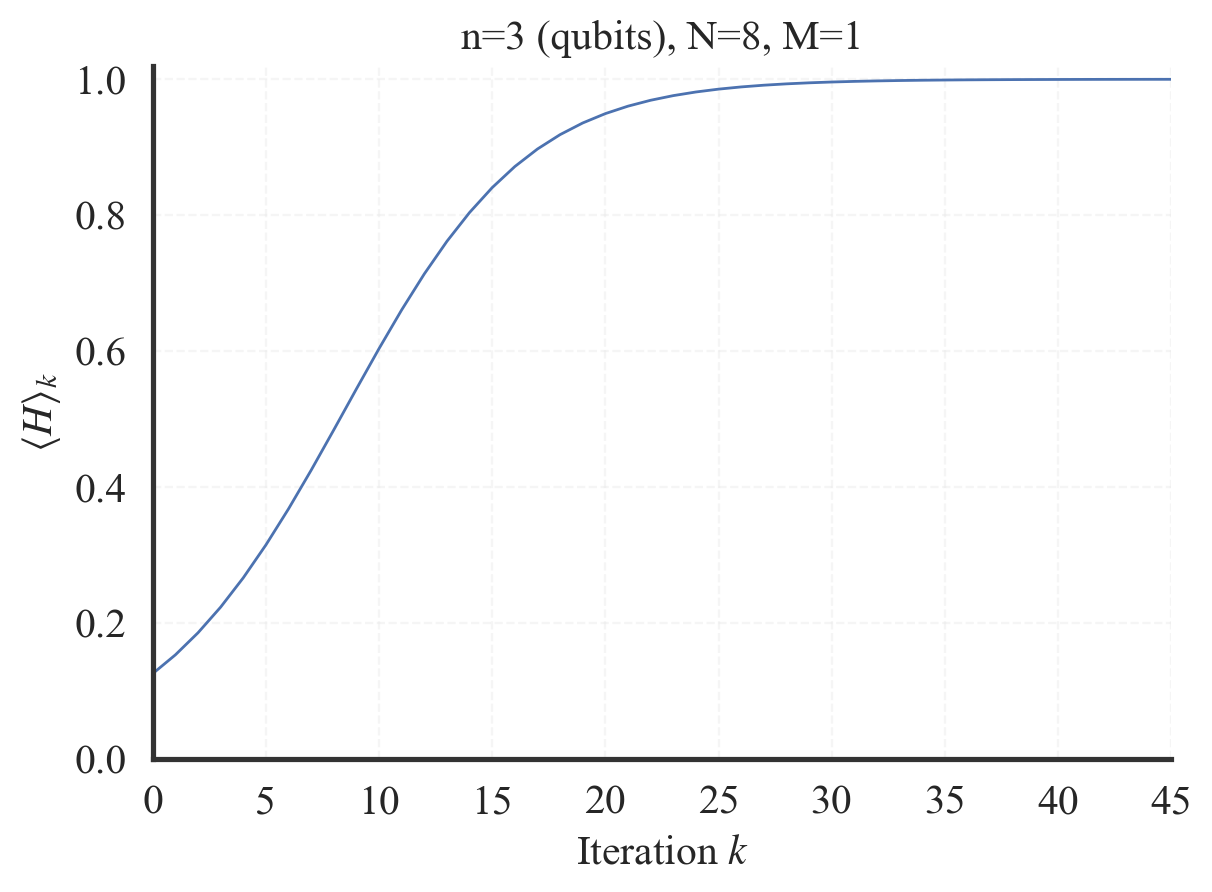

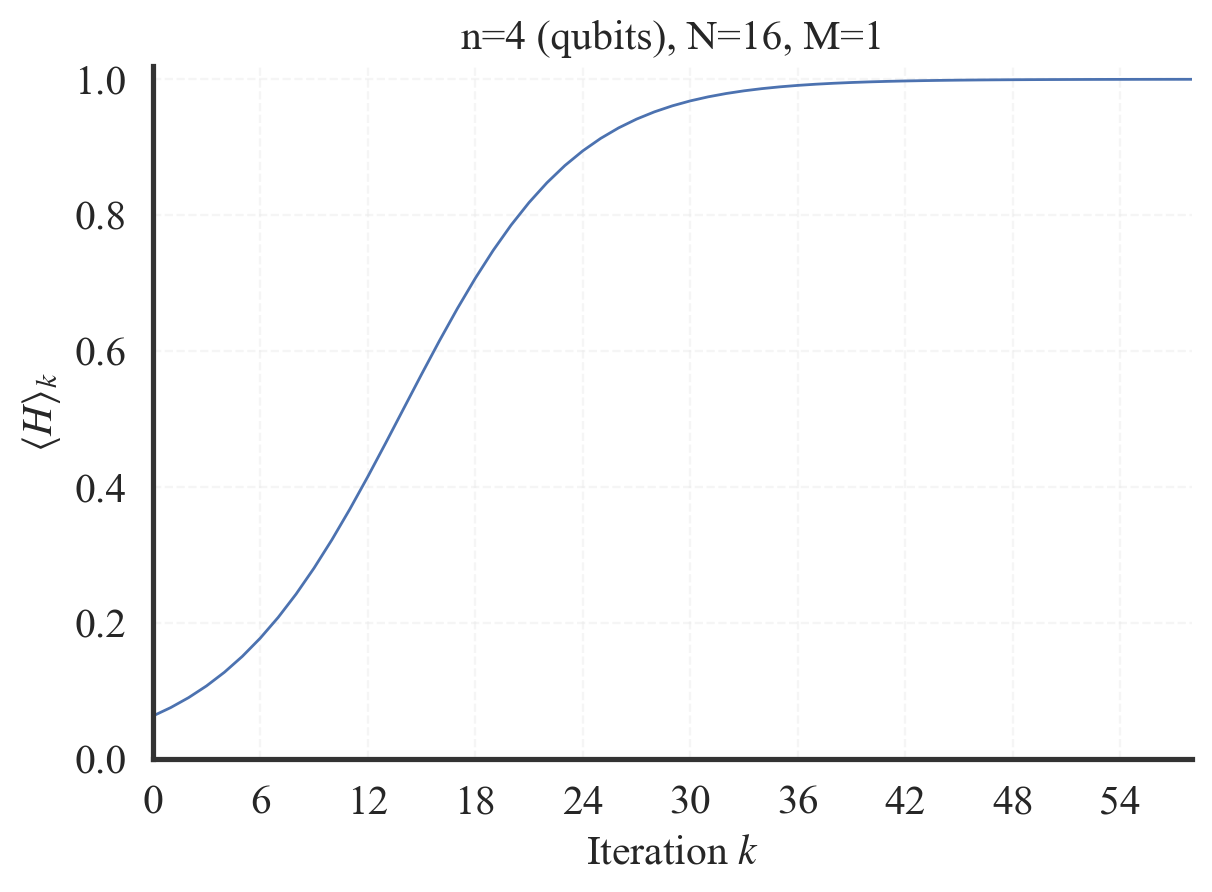

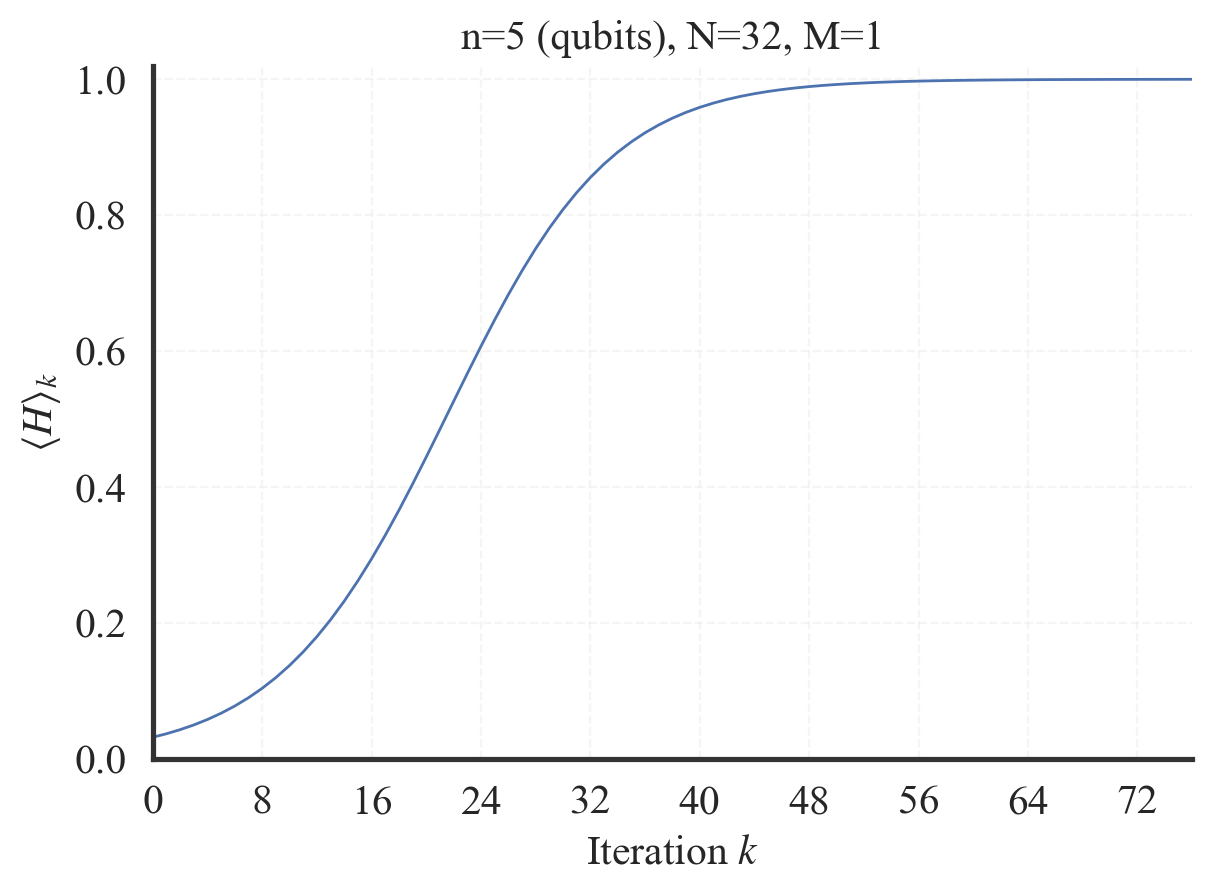

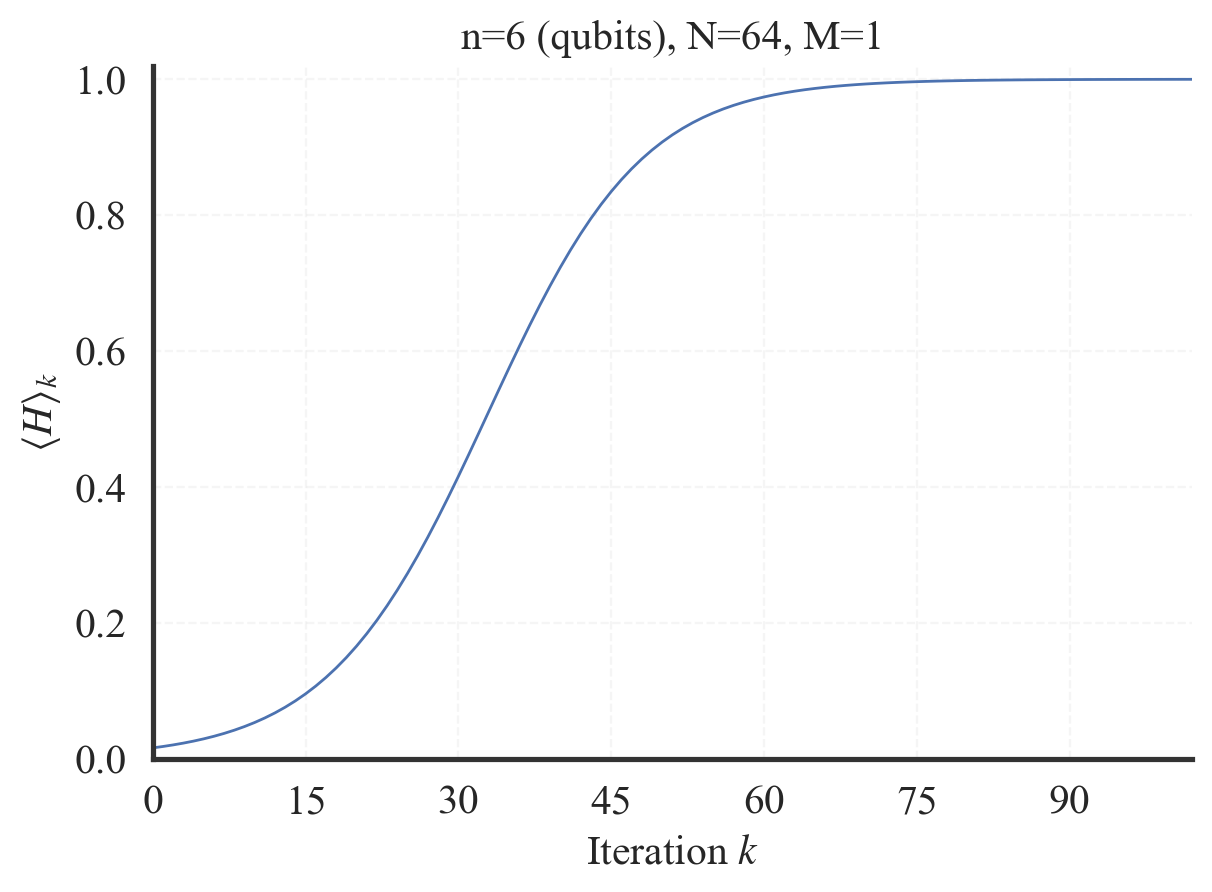

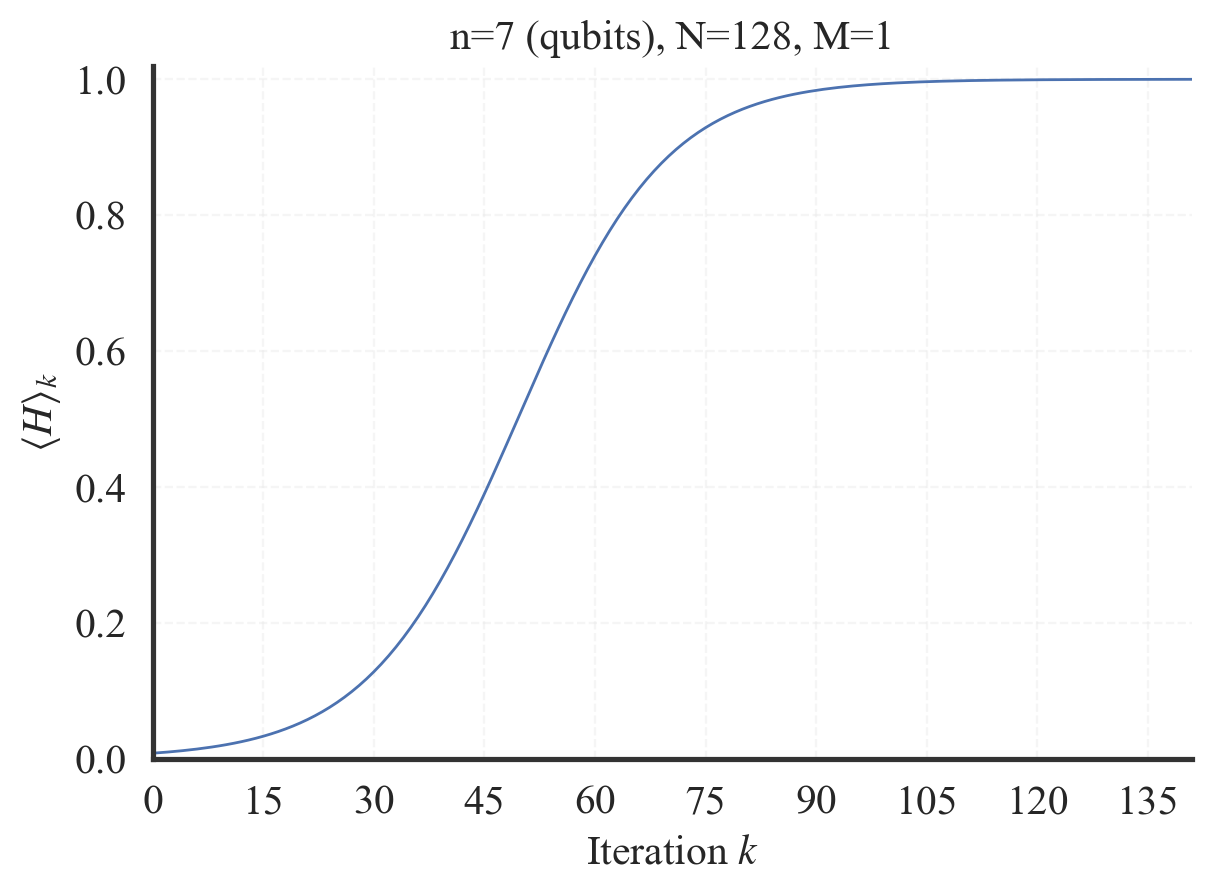

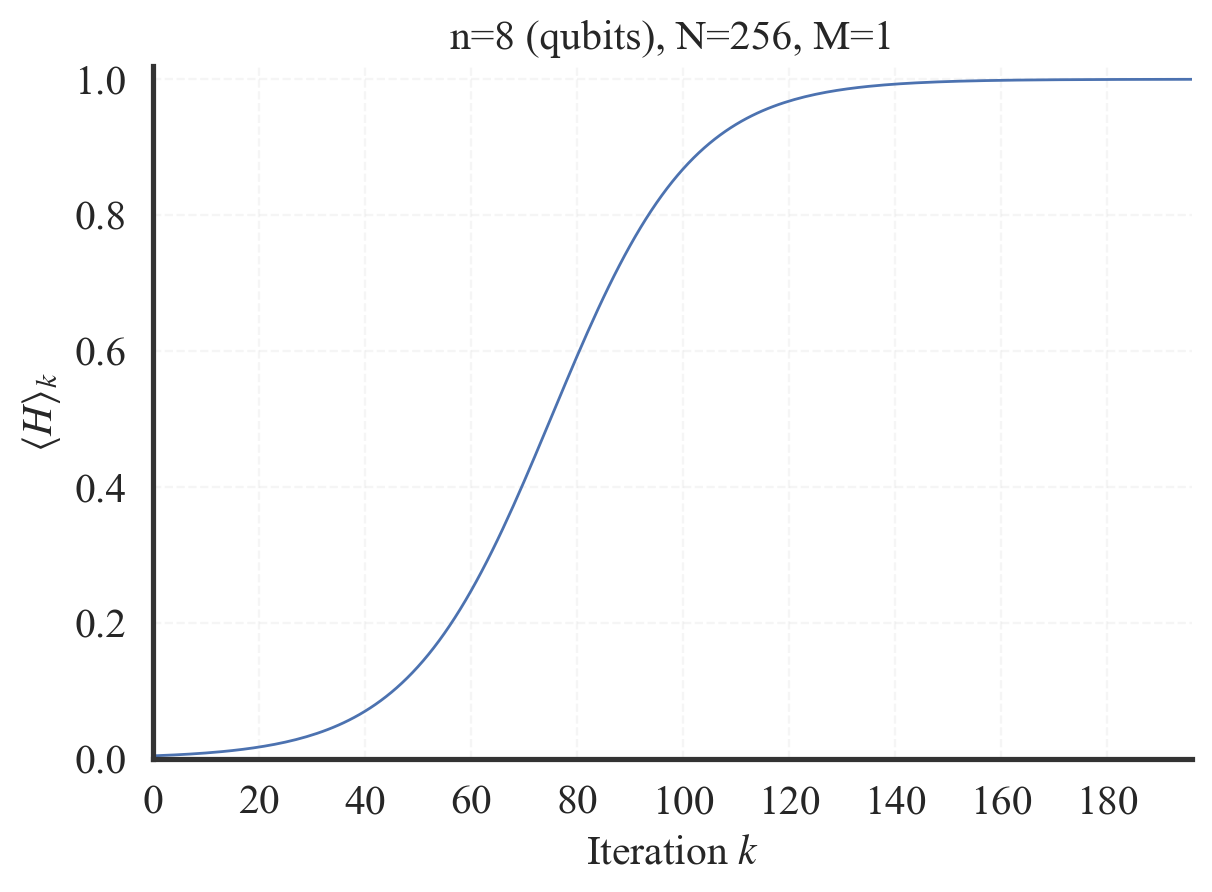

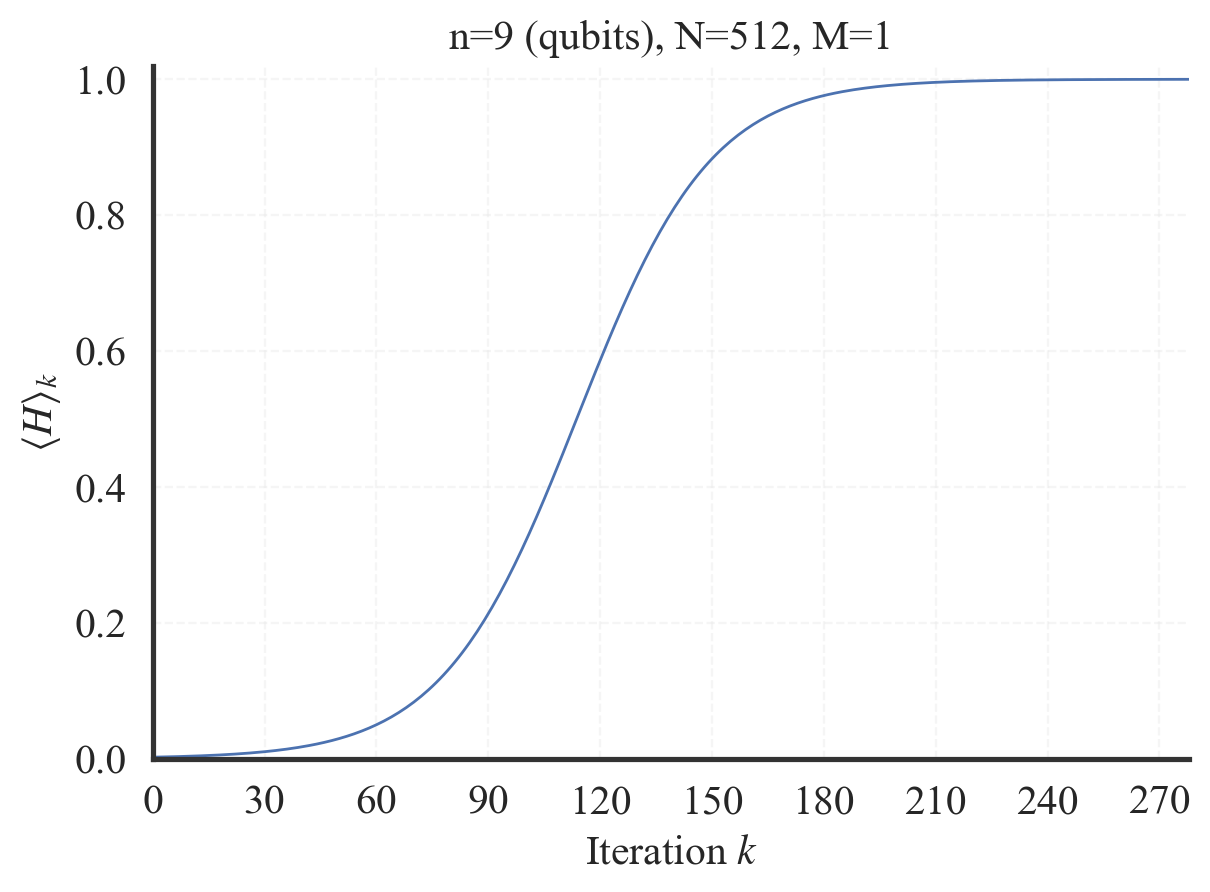

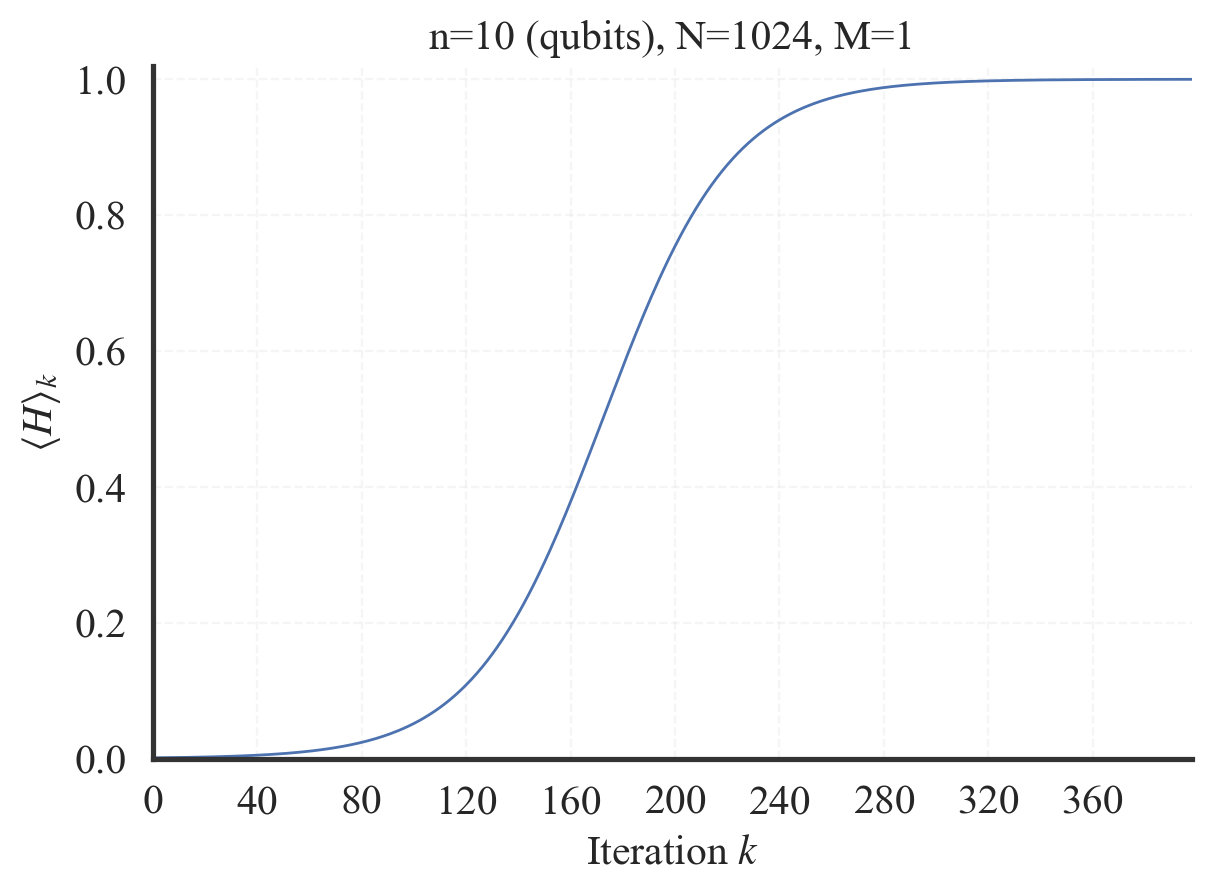

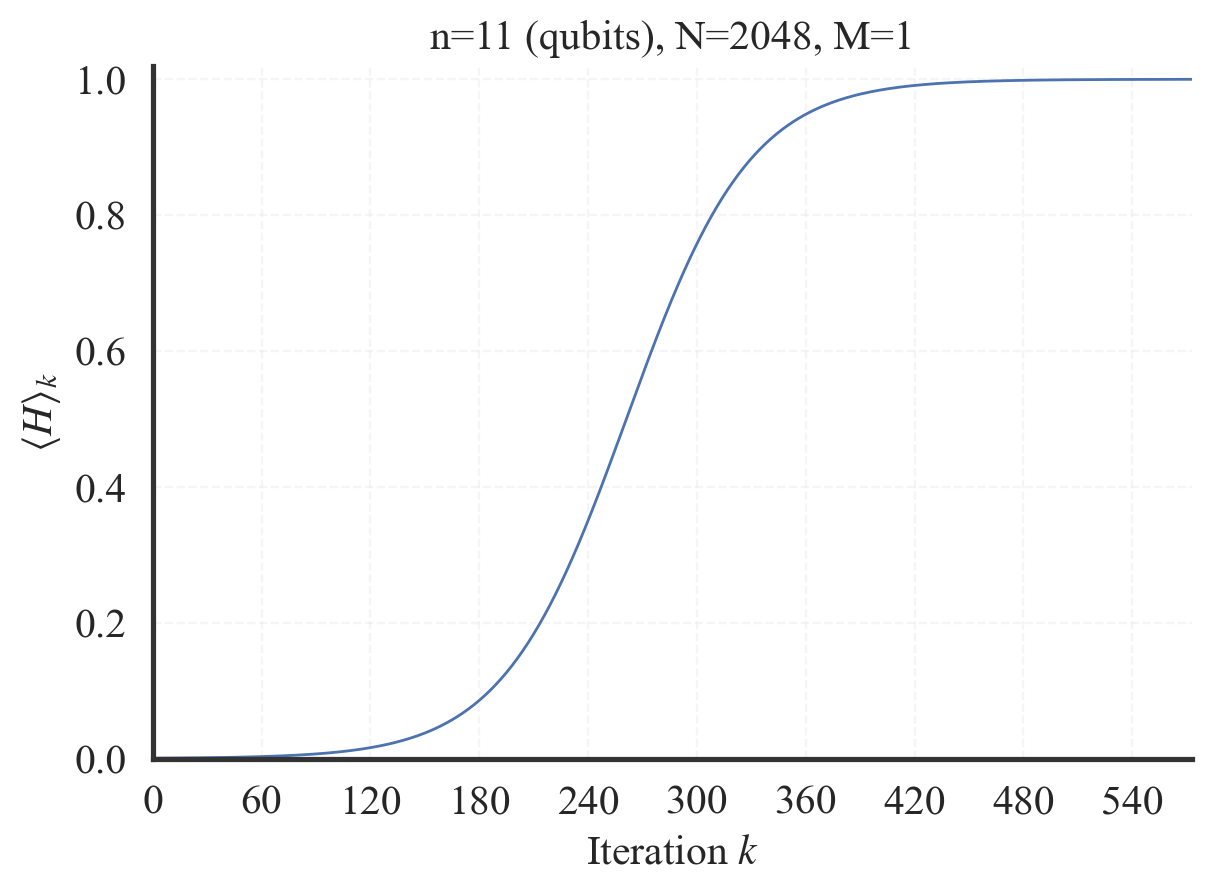

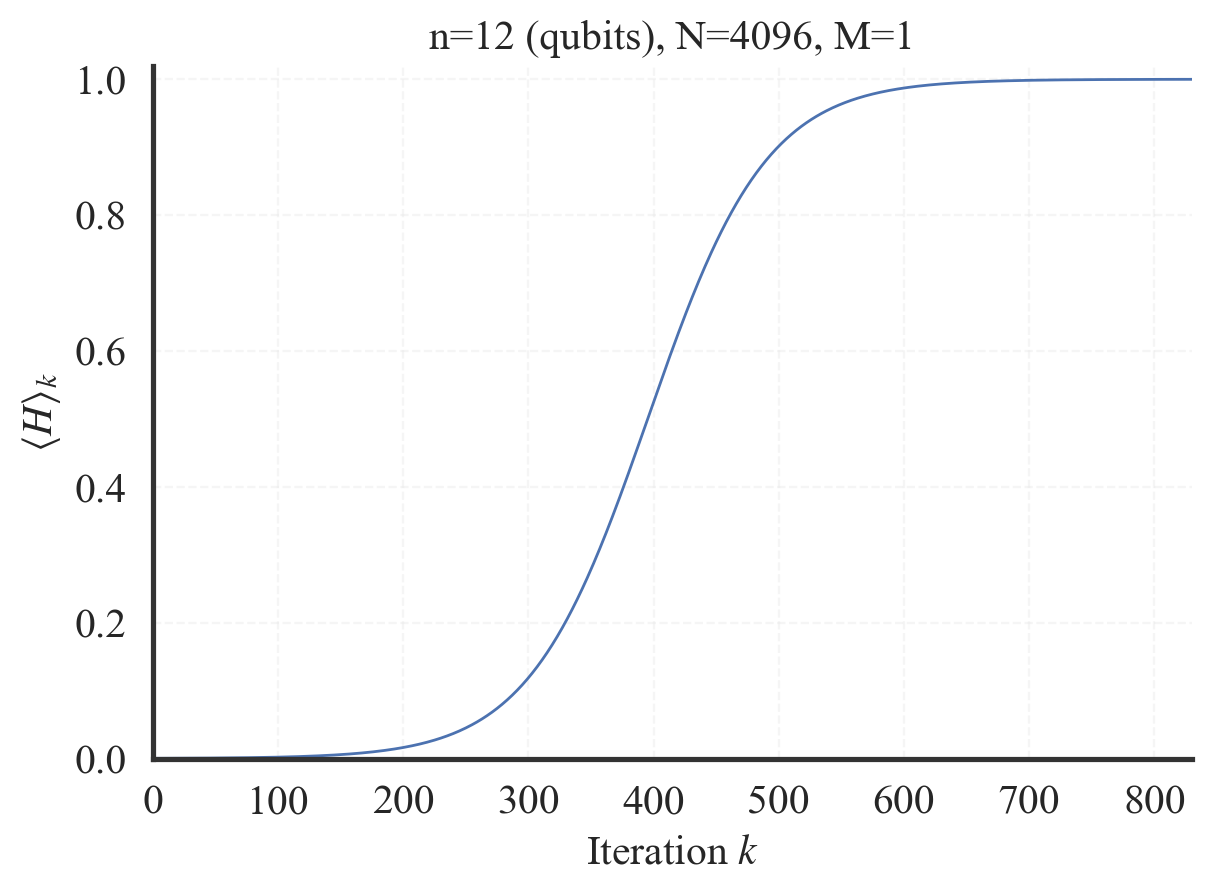

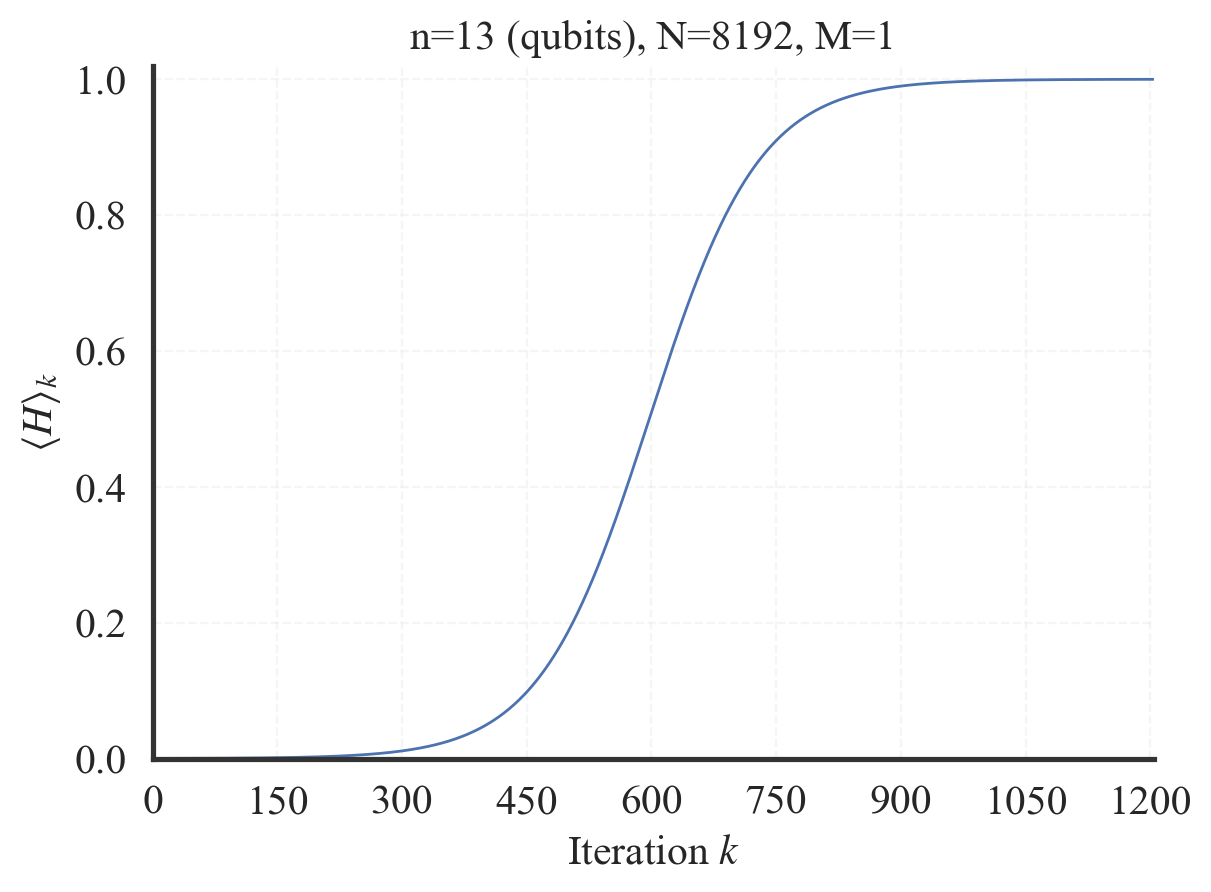

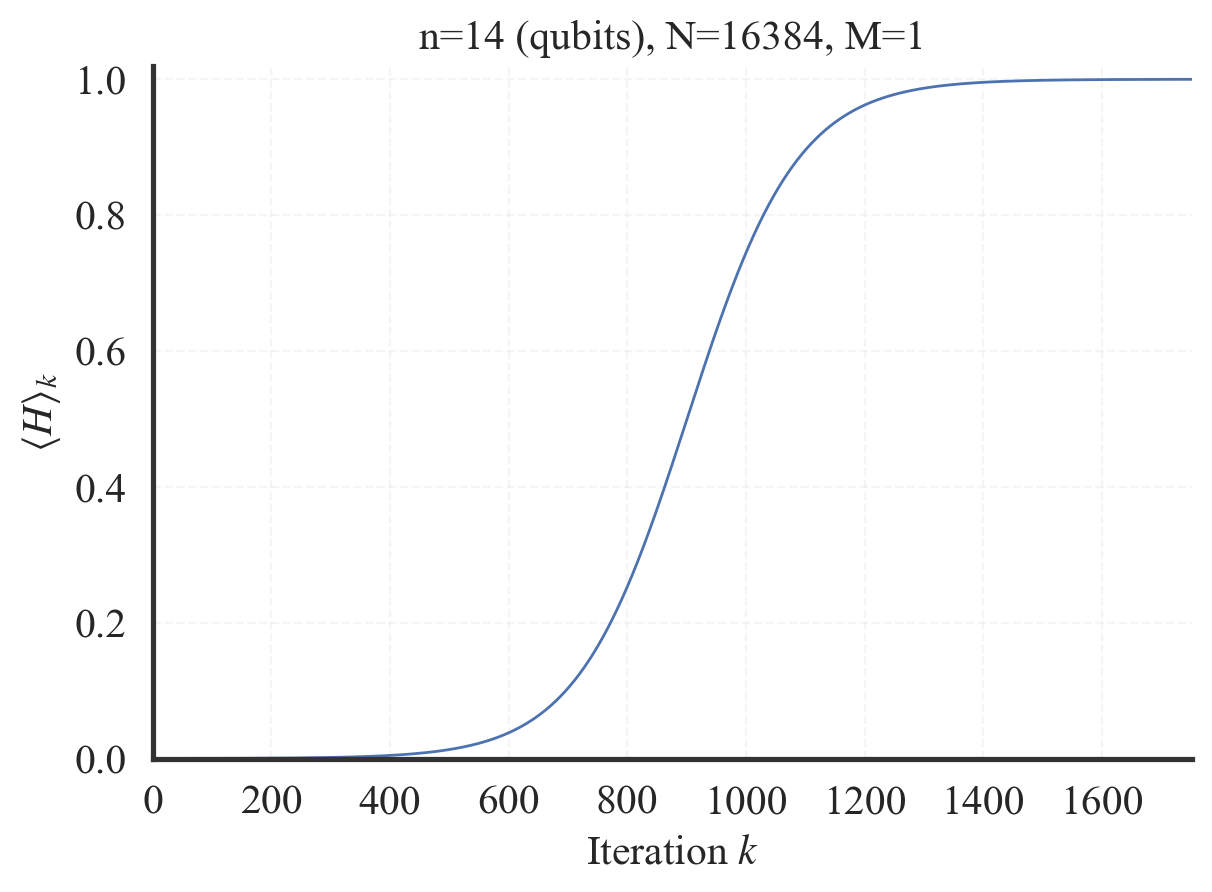

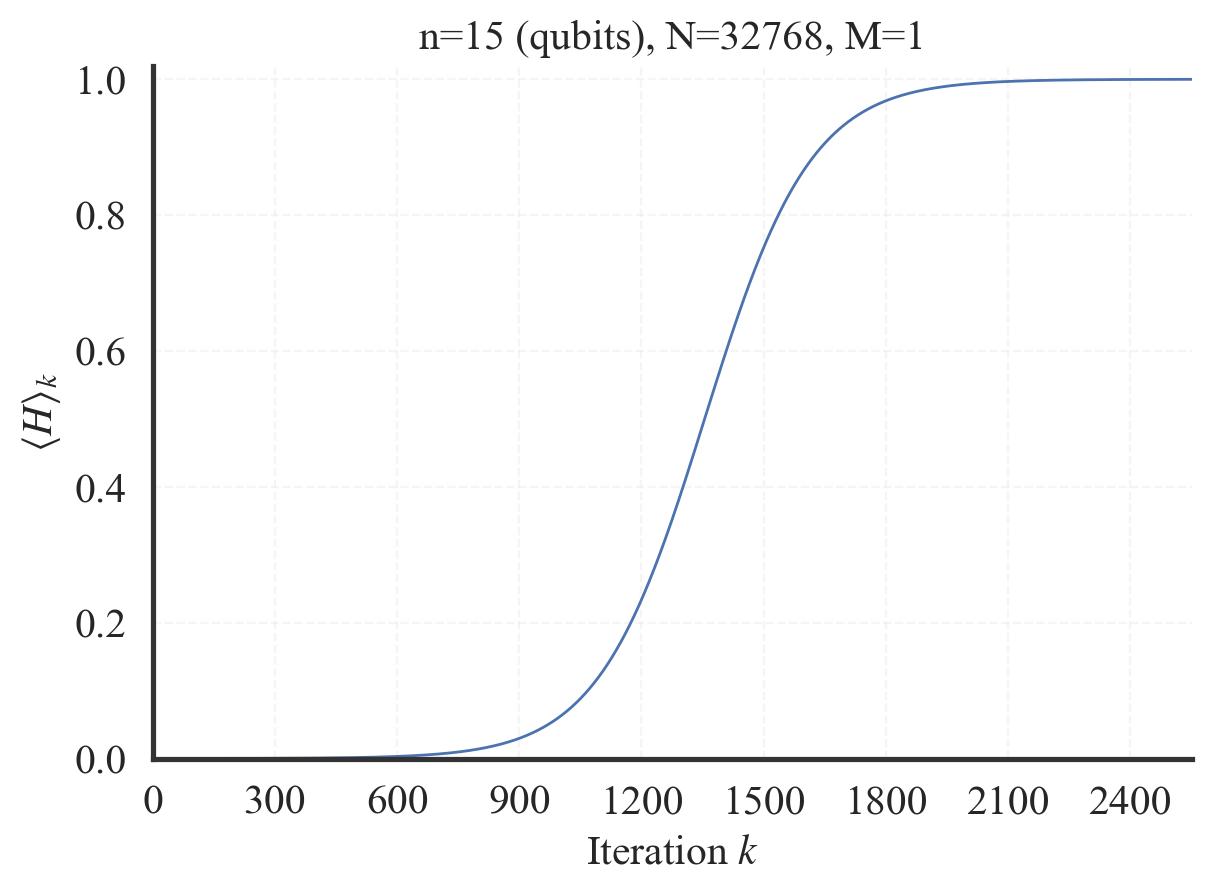

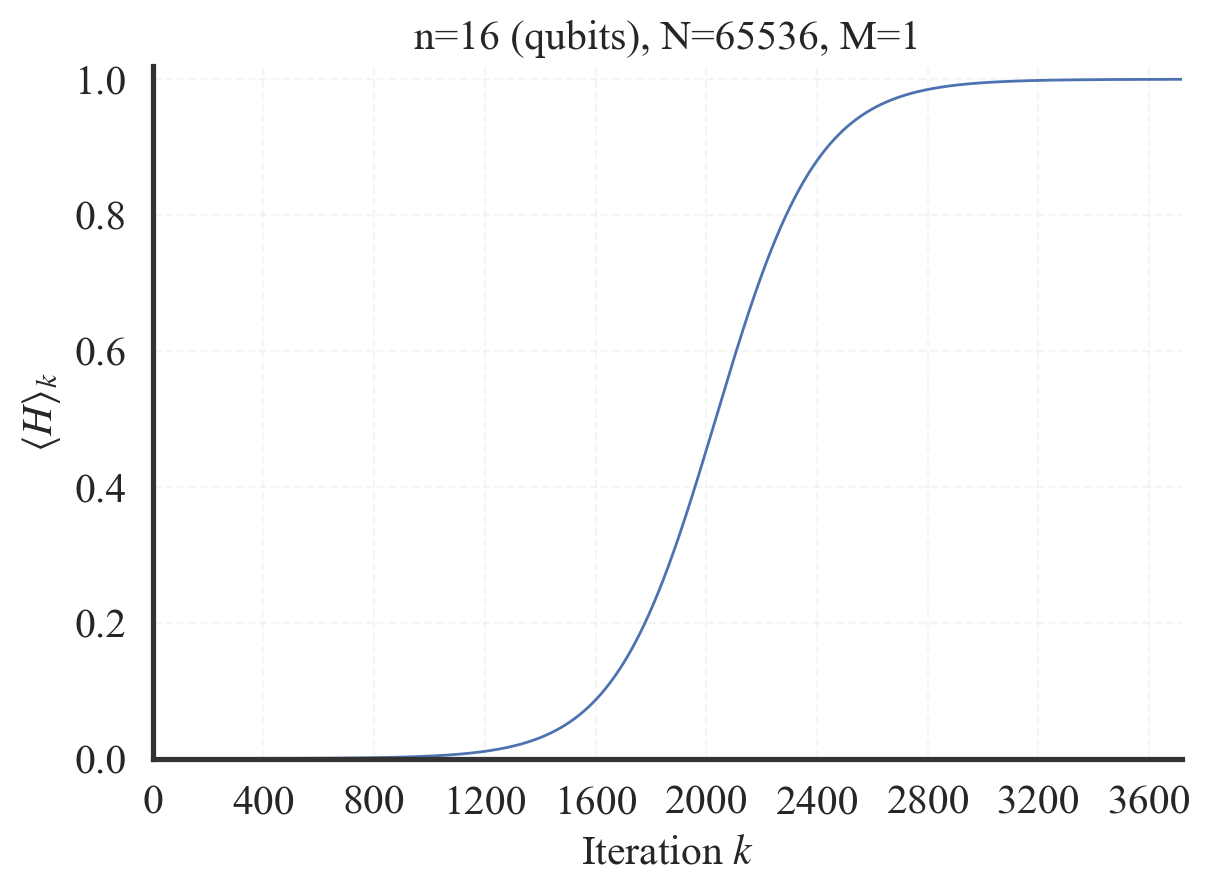

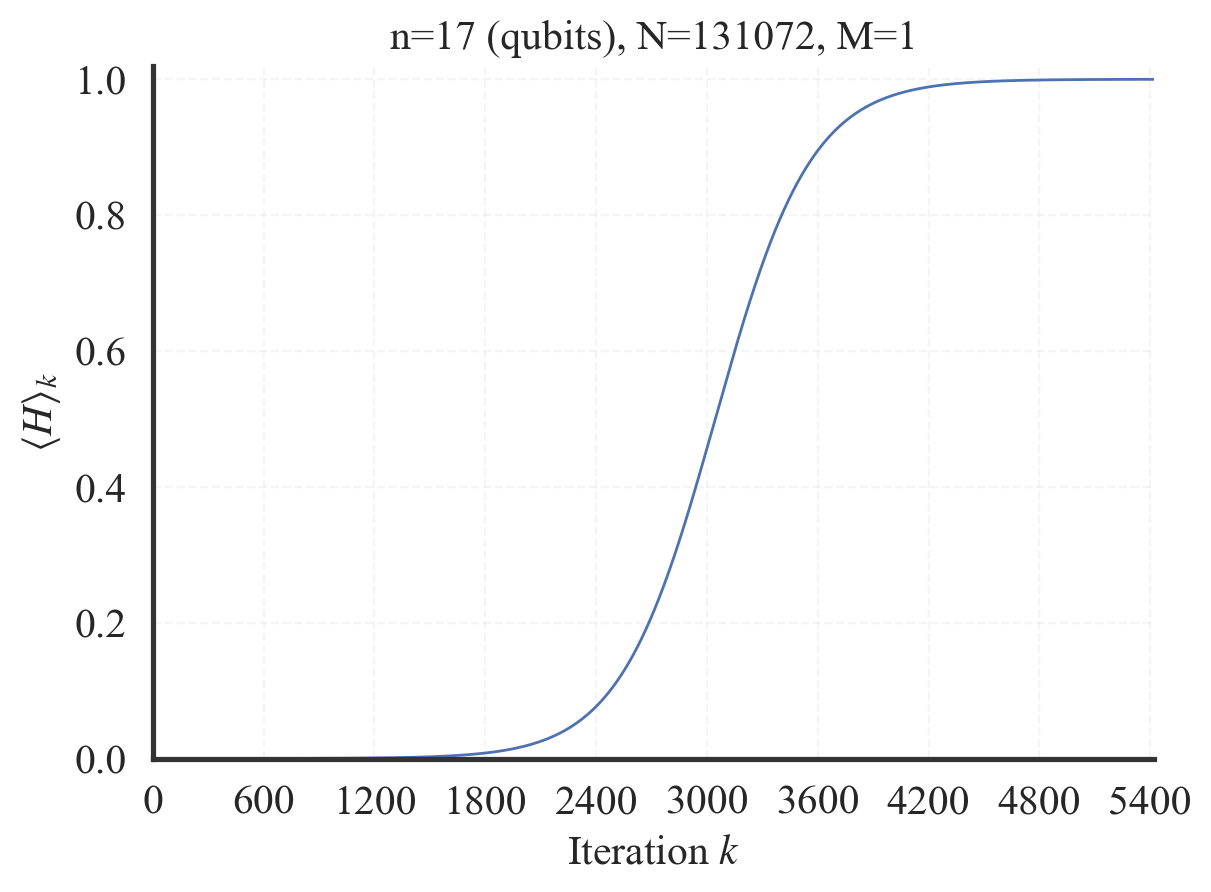

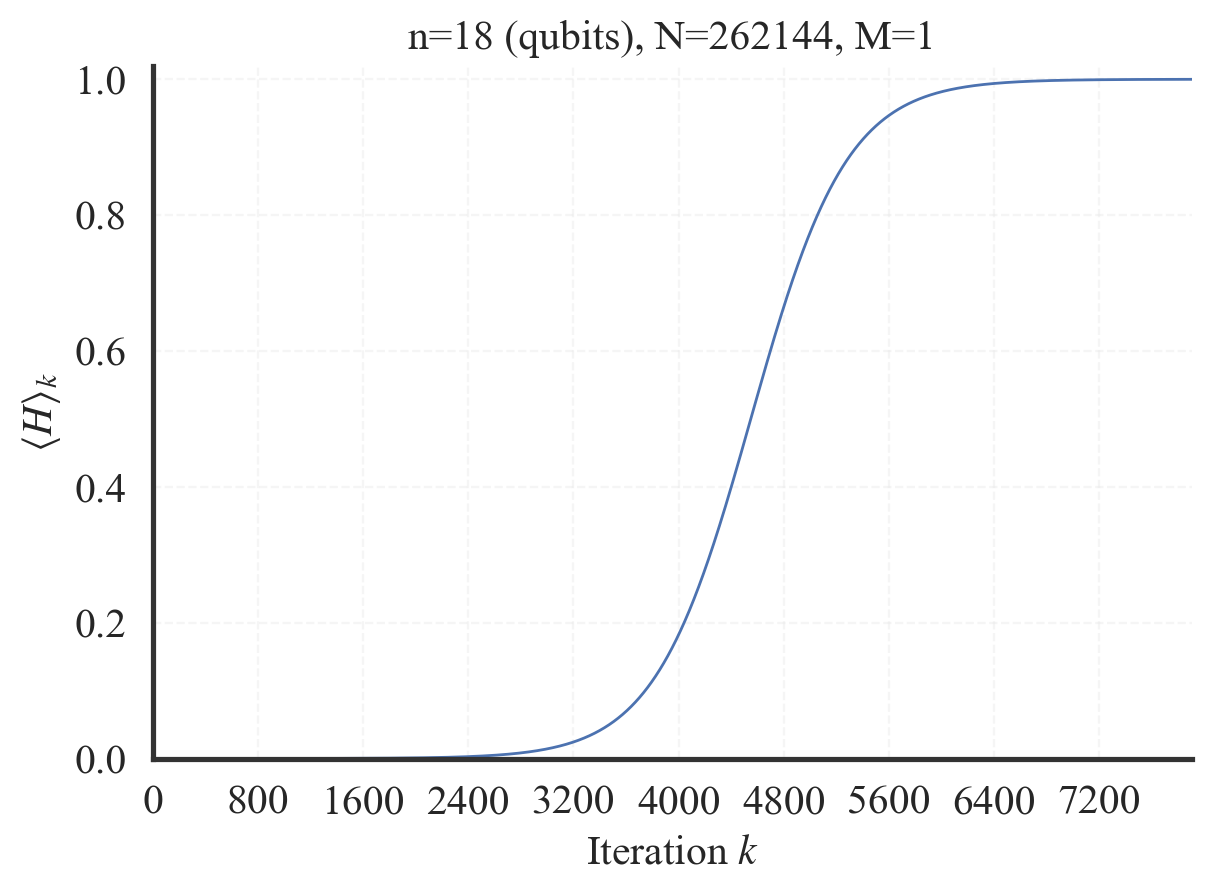

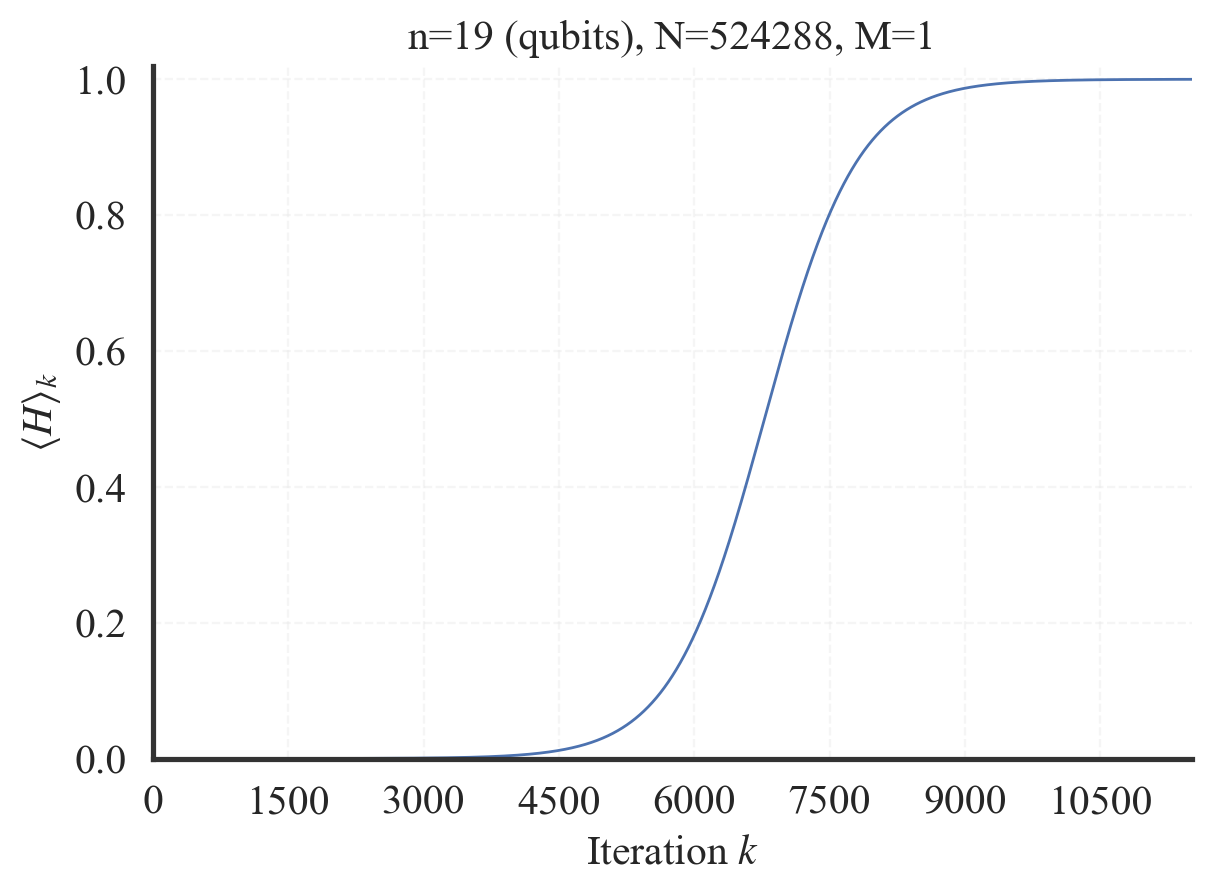

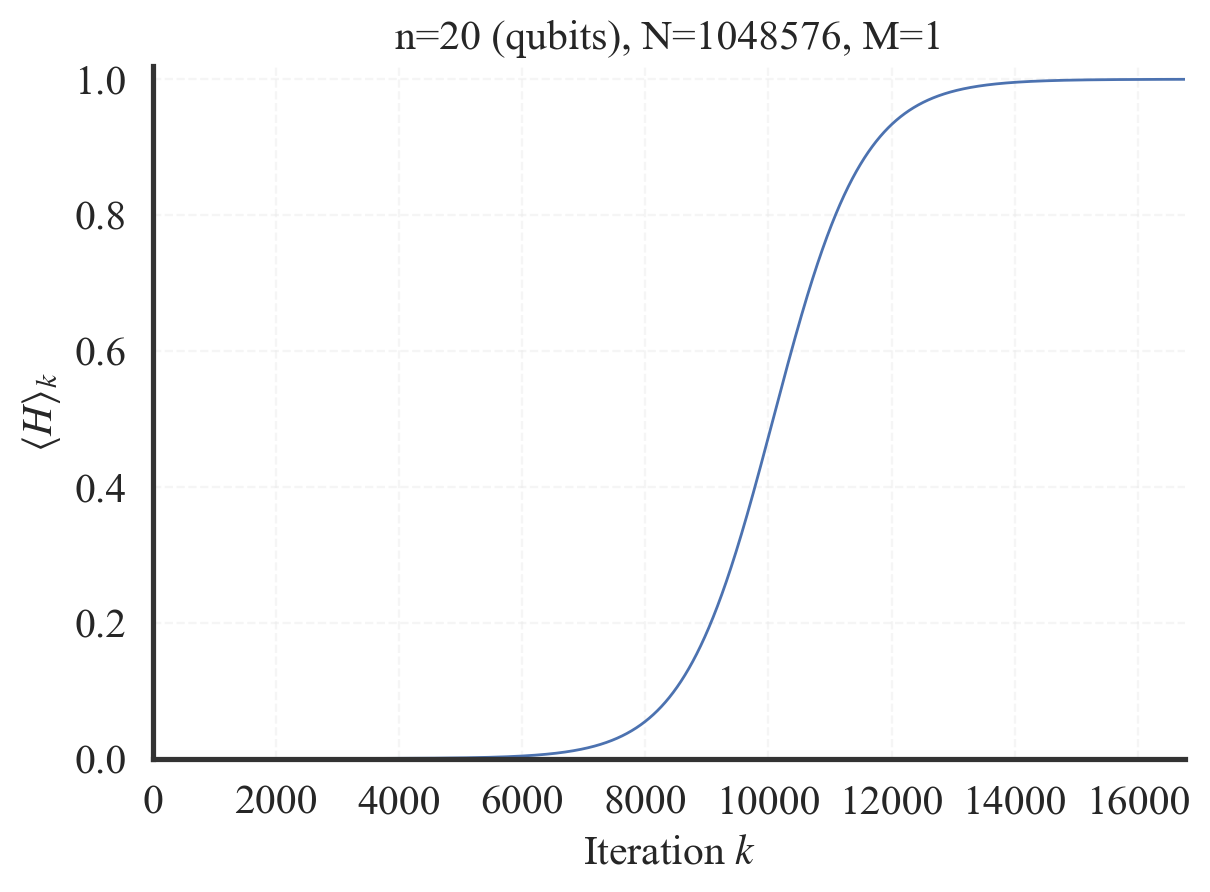

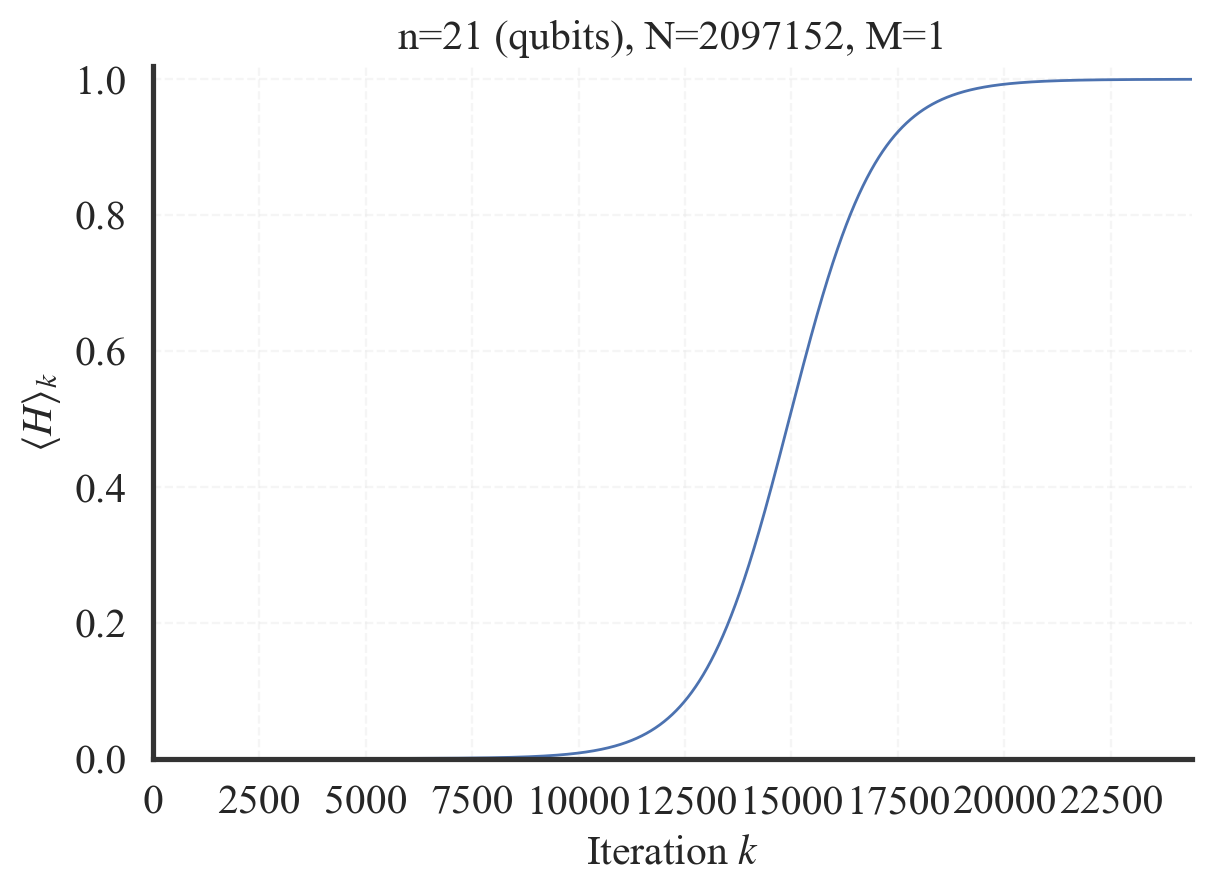

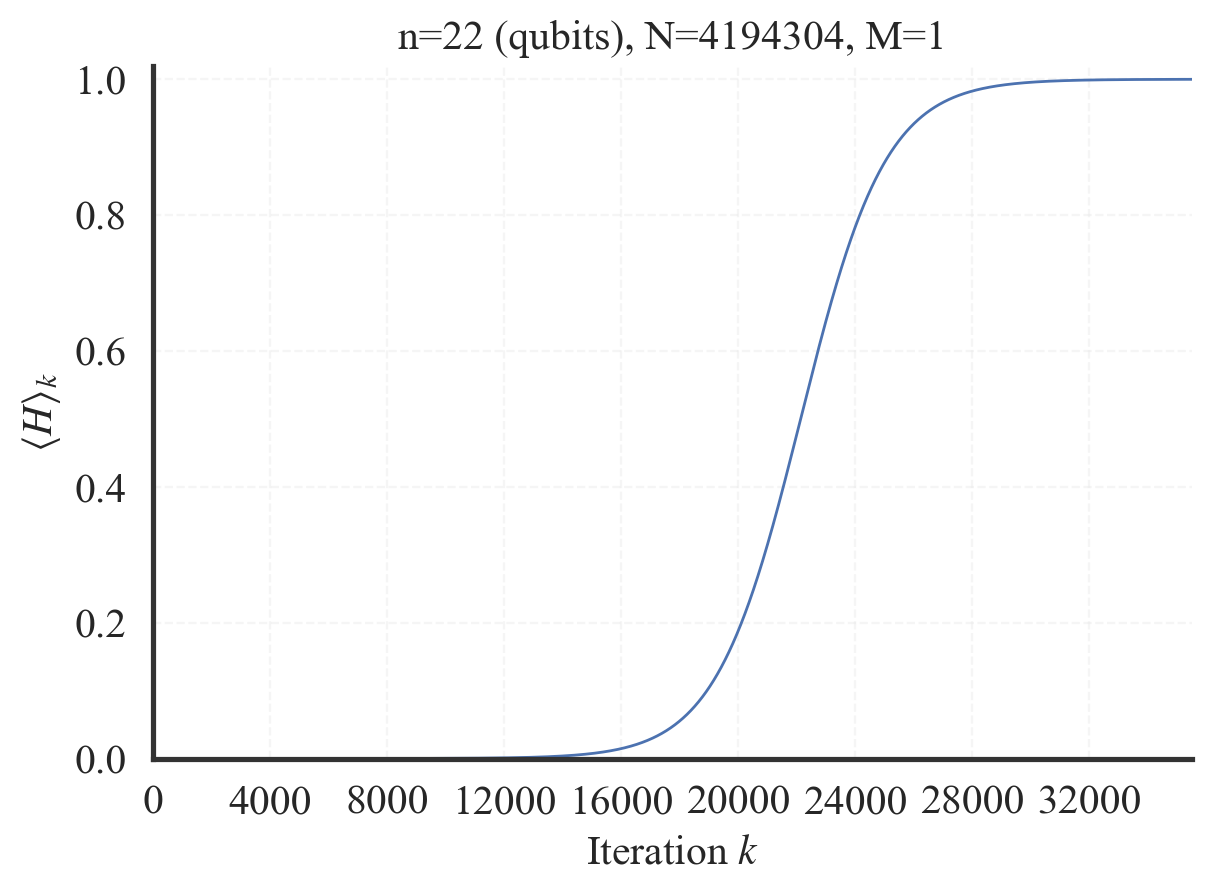

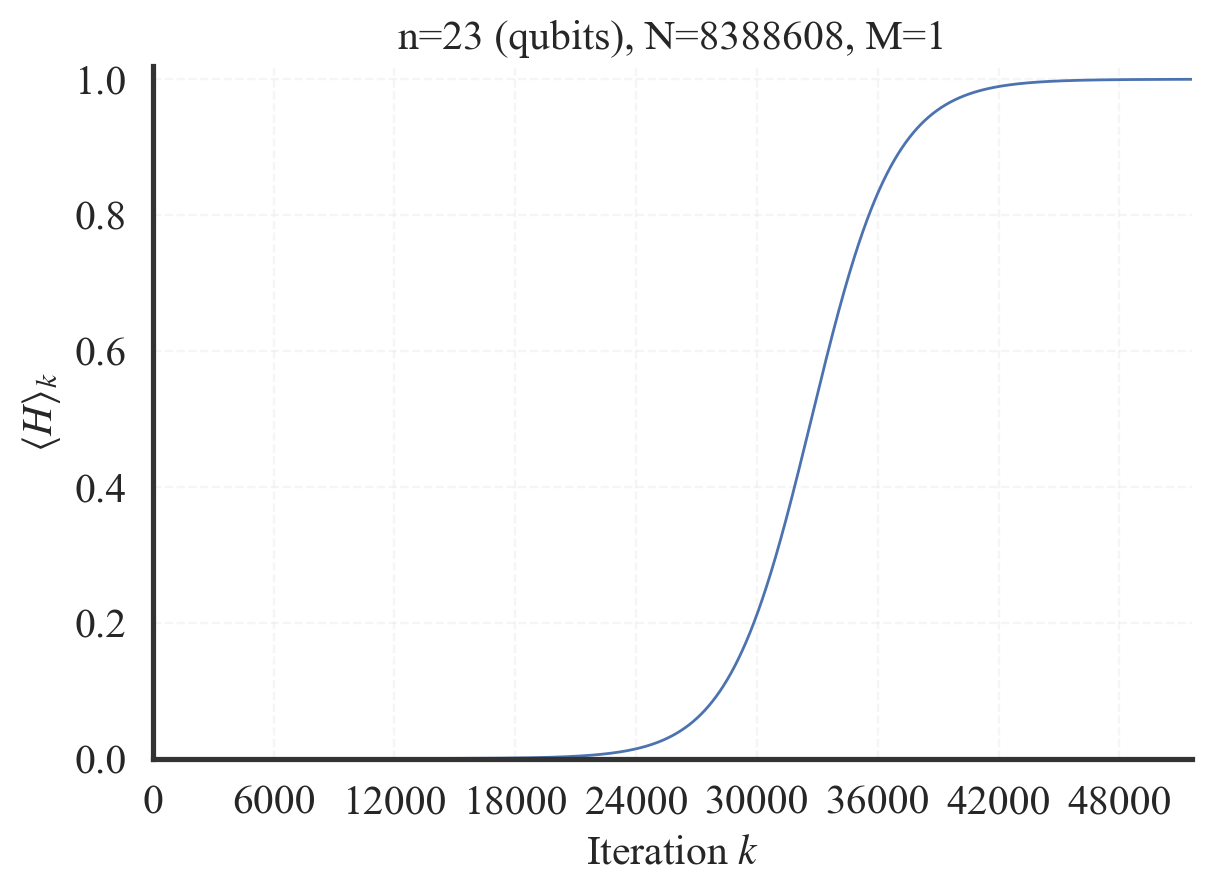

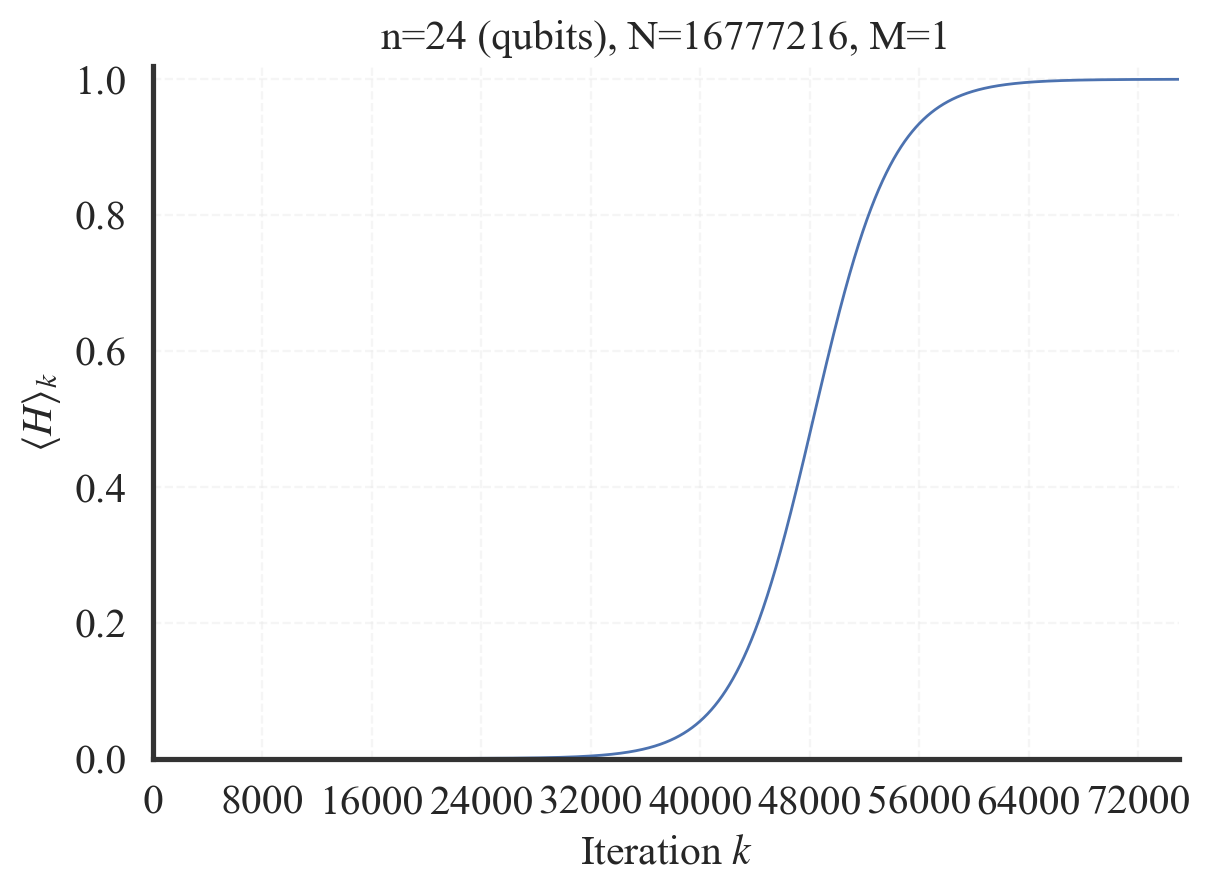

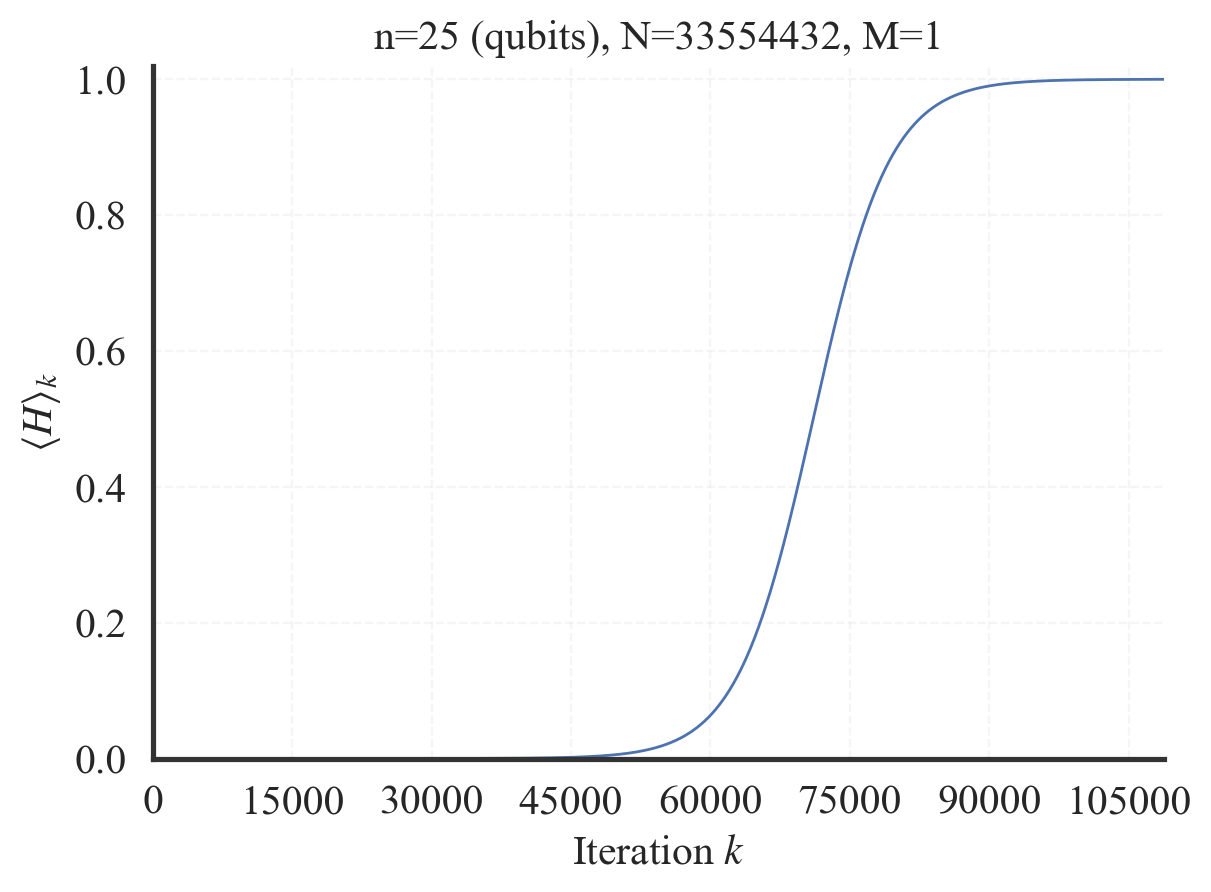

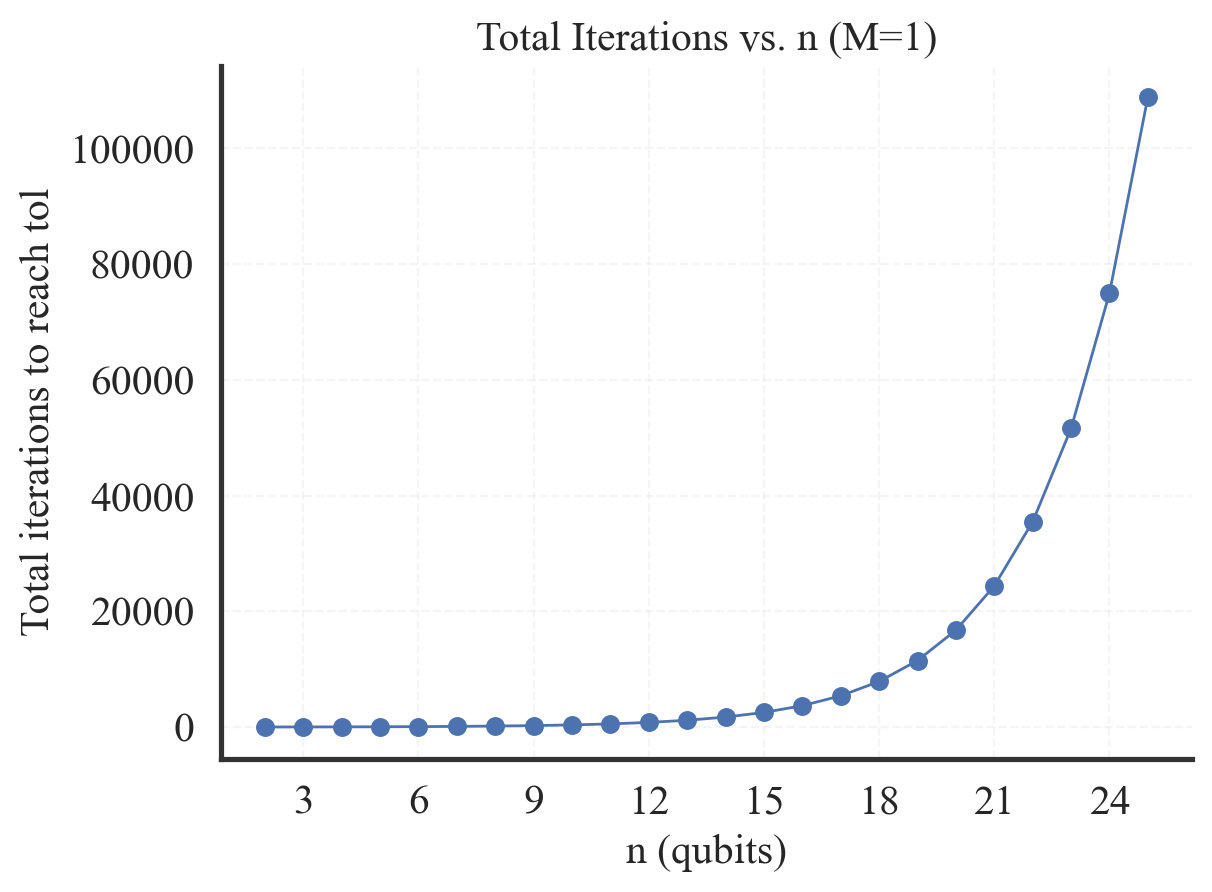

In [28]:

# run + plot each n separately; also collect iteration counts
iters_per_n = []   # total iterations (not counting q0) for each n, aligned with n_values

for n in n_values:
    q_list = run_once(n, M_mat, M, T, tol, step='fixed')
    iters = np.arange(len(q_list))  # includes k=0 for q0
    last_t = len(q_list) - 1        # final iteration index (q_last corresponds to this)

    # store total iterations (excluding q0)
    iters_per_n.append(last_t)

    # plot this run immediately
    fig, ax = plt.subplots()
    ax.plot(iters, q_list, linewidth=1)
    ax.set_ylim(0, 1.02)
    ax.set_xlabel(r"Iteration $k$")
    ax.set_ylabel(r'$\langle H \rangle_k$')
    N = 2**n
    q0 = M / N
    ax.set_title(f"n={n} (qubits), N={N}, M={M}")
    ax.grid(True, linestyle='--', alpha=0.4)

    # --- ensure x-axis marks the final iteration explicitly ---
    # 1) set exact x-limits to include the last iteration
    ax.set_xlim(0, last_t)
    # 2) place ticks that include the last_t (and a few spaced ticks)
    tick_positions = np.unique(np.linspace(0, last_t, num=min(6, last_t+1), dtype=int))
    ax.set_xticks(tick_positions)
    # 3) keep ticks as integers
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # # optional: annotate the last point
    # ax.plot(last_t, q_list[-1], marker='o')
    # ax.annotate(f"k={last_t}", (last_t, q_list[-1]),
    #             textcoords="offset points", xytext=(6, 6))

    fig.tight_layout()
    plt.show()

# --- summary: total iterations as a function of m ---
fig, ax = plt.subplots()
ax.plot(n_values, iters_per_n, marker='o', linewidth=1)
ax.set_xlabel("n (qubits)")
ax.set_ylabel("Total iterations to reach tol")
ax.set_title(f"Total Iterations vs. n (M={M})")
ax.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
plt.show()

# # (optional) quick printout for reference
# for m, itc in zip(n_values, iters_per_n):
#     print(f"m={m:2d} -> iterations={itc}")


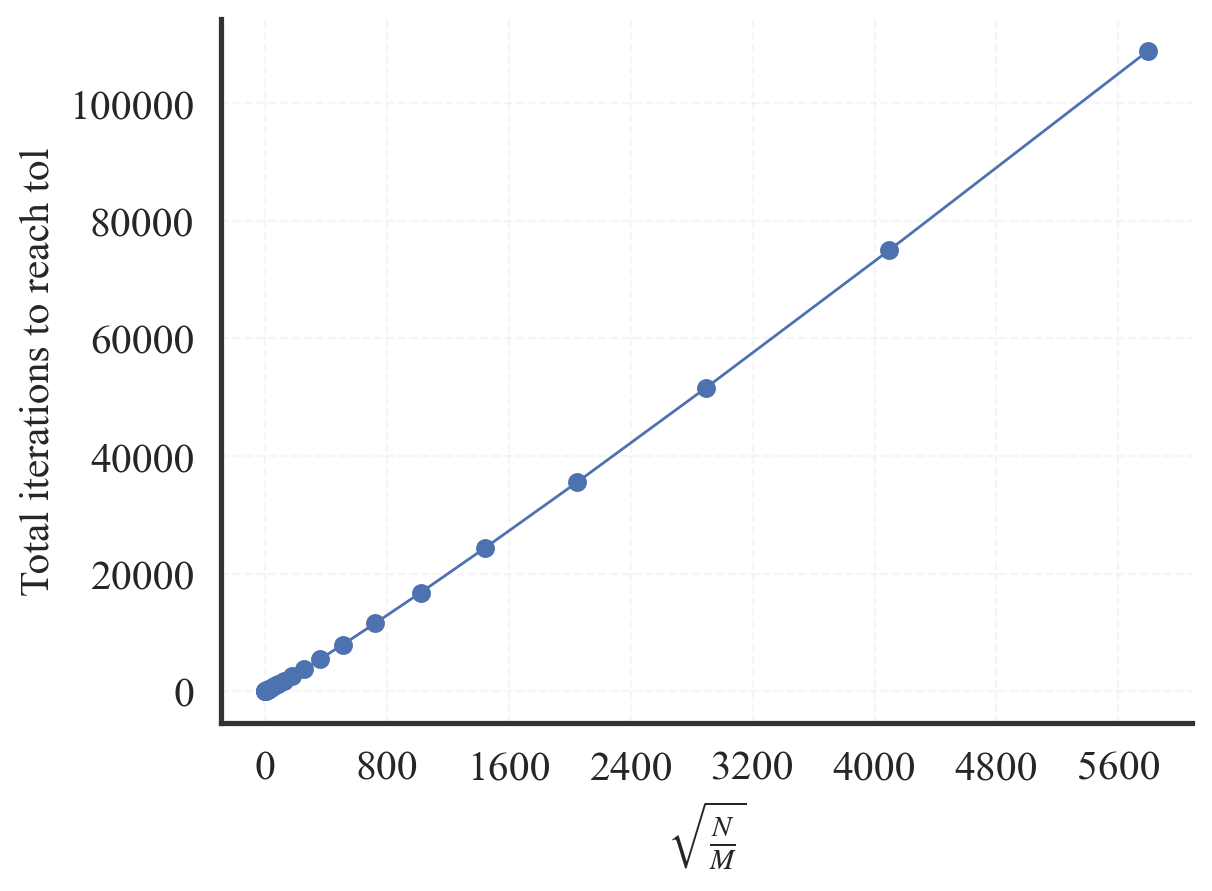

qubits= 2, N=         4, iter=36, ratio(call#H/sqrt(N/M))=36.000
qubits= 3, N=         8, iter=45, ratio(call#H/sqrt(N/M))=31.820
qubits= 4, N=        16, iter=58, ratio(call#H/sqrt(N/M))=29.000
qubits= 5, N=        32, iter=76, ratio(call#H/sqrt(N/M))=26.870
qubits= 6, N=        64, iter=102, ratio(call#H/sqrt(N/M))=25.500
qubits= 7, N=       128, iter=141, ratio(call#H/sqrt(N/M))=24.926
qubits= 8, N=       256, iter=196, ratio(call#H/sqrt(N/M))=24.500
qubits= 9, N=       512, iter=278, ratio(call#H/sqrt(N/M))=24.572
qubits=10, N=      1024, iter=398, ratio(call#H/sqrt(N/M))=24.875
qubits=11, N=      2048, iter=573, ratio(call#H/sqrt(N/M))=25.323
qubits=12, N=      4096, iter=830, ratio(call#H/sqrt(N/M))=25.938
qubits=13, N=      8192, iter=1204, ratio(call#H/sqrt(N/M))=26.605
qubits=14, N=     16384, iter=1752, ratio(call#H/sqrt(N/M))=27.375
qubits=15, N=     32768, iter=2552, ratio(call#H/sqrt(N/M))=28.196
qubits=16, N=     65536, iter=3720, ratio(call#H/sqrt(N/M))=29.062
qubits=17,

In [29]:

# --- summary: total iterations as a function of n=2**m ---
N_values = [2**n for n in n_values]
sqrt_nm_values = [np.sqrt(2**n / M) for n in n_values]

fig, ax = plt.subplots()
ax.plot(sqrt_nm_values, iters_per_n, marker='o', linewidth=1)
# ax.set_xlabel(fr"$\sqrt{{\frac{{N}}{{M}}}}$, N=2^n, M={M}")
ax.set_xlabel(fr"$\sqrt{{\frac{{N}}{{M}}}}$")
ax.set_ylabel("Total iterations to reach tol")
# ax.set_title(r"Total Iterations vs. $\sqrt{\frac{N}{M}}$")
ax.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
plt.show()

# (optional) quick printout for reference
for n, N, sn, itc in zip(n_values, N_values, sqrt_nm_values, iters_per_n):
    print(f"qubits={n:2d}, N={N:10d}, iter={itc}, ratio(call#H/sqrt(N/M))={K_num_H*itc/sn:.3f}")


# size scaling

three retractions, 5-factor use exact line search and 1/L, tow figres, zoomed

In [30]:
# --- config ---
n_values = list(range(2, 26))  # 2..15 inclusive
M = 1  # rank of H
T = 150000
tol = 1e-4
delta = np.pi  # default

def M_mat_5_family(t, x, y, q0):
    return M_mat_5_family_factor(t, x, y, q0, delta)

def M_mat_6_family(t, x, y, q0):
    return M_mat_6_family_factor(t, x, y, q0, delta)

# Store results for all four cases
results = {}
factor_configs = [
    ('5-factor (fixed 1/L)', M_mat_5_family, 2, 'fixed'),
    ('5-factor (els)',   M_mat_5_family, 2, 'els'),
    ('6-factor (els)',   M_mat_6_family, 3, 'els'),
    ('8-factor (els)',   M_mat_8_factor, 4, 'els')
]

for factor_name, M_mat, K_num_H, step_method in factor_configs:
    iters_per_n = []
    for n in n_values:
        q_list = run_once(n, M_mat, M, T, tol, step=step_method)
        last_t = len(q_list) - 1       # 迭代次数
        iters_per_n.append(last_t)
    results[factor_name] = {
        'iters': iters_per_n,          # 先存迭代次数
        'K_num_H': K_num_H             # 每一步调用 H 的次数
    }


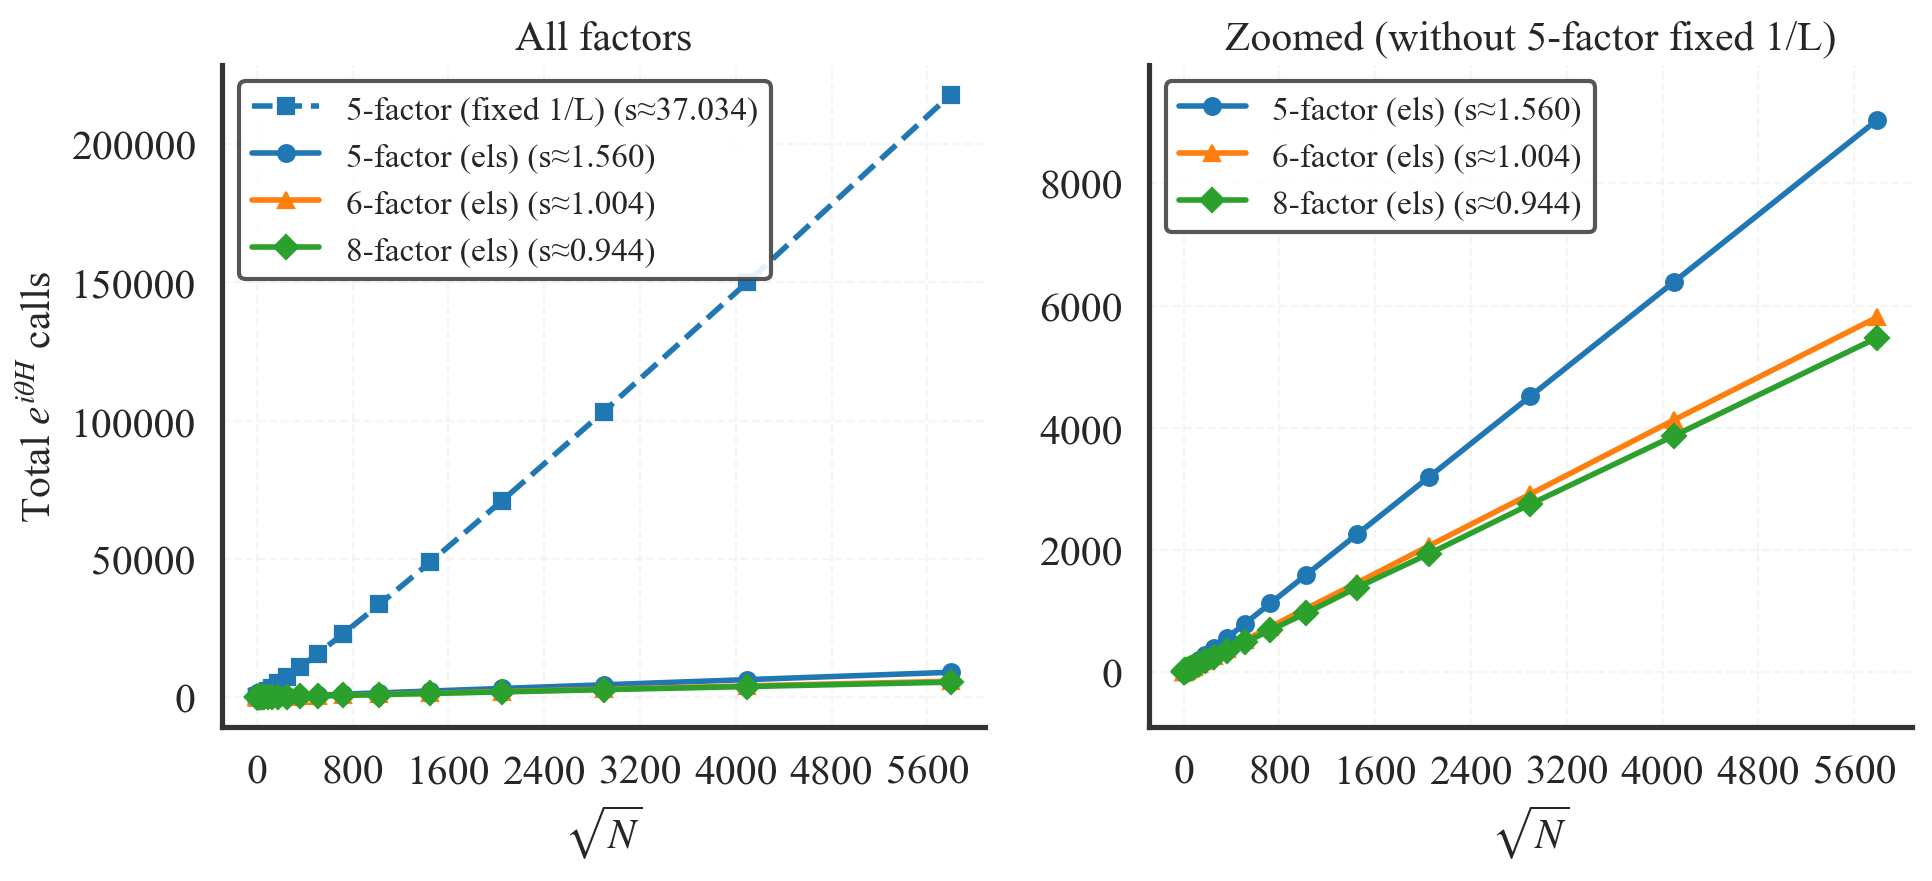

In [31]:

# --- x 轴: sqrt(N/M) ---
N_values = [2**n for n in n_values]
sqrt_nm_values = np.array([np.sqrt(2**n / M) for n in n_values])  # x

# --- 计算每条曲线的近似“斜率”：对总 H 调用次数做线性拟合 ---
# y = K_num_H * iterations
slopes = {}
for factor_name, _, _, _ in factor_configs:
    iters = np.array(results[factor_name]['iters'])
    K_num_H = results[factor_name]['K_num_H']
    total_H_calls = K_num_H * iters
    slope, intercept = np.polyfit(sqrt_nm_values, total_H_calls, 1)
    slopes[factor_name] = slope

# --- Plot with two subplots: left = all 4, right = zoom (without 5-factor fixed) ---

fig, (ax_all, ax_zoom) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

colors     = ['#1f77b4', '#1f77b4', '#ff7f0e', '#2ca02c']
markers    = ['s',        'o',        '^',        'D']
linestyles = ['--',        '-',       '-',        '-']

# ---------------- 左图：4 条曲线全部画在一起，并在 legend 中标出斜率 ----------------
for (factor_name, _, _, _), color, marker, linestyle in zip(factor_configs, colors, markers, linestyles):
    iters = np.array(results[factor_name]['iters'])
    K_num_H = results[factor_name]['K_num_H']
    total_H_calls = K_num_H * iters          # 真正的 y 轴

    slope = slopes[factor_name]              # 基于 total_H_calls 拟合出来的斜率
    label = f"{factor_name} (s≈{slope:.3f})"

    ax_all.plot(
        sqrt_nm_values, total_H_calls,
        marker=marker, linewidth=2,
        label=label, color=color,
        markersize=6, linestyle=linestyle
    )

ax_all.set_xlabel(r"$\sqrt{N}$")
ax_all.set_ylabel(r"Total $e^{i\theta H}$ calls")
ax_all.set_title(r"All factors")
ax_all.grid(True, linestyle='--', alpha=0.4)
ax_all.legend(loc='best')
ax_all.xaxis.set_major_locator(MaxNLocator(integer=True))


# ---------------- 右图：只画 3 条（去掉 5-factor fixed），并放大 y 轴 ----------------
zoom_y_min = float('inf')
zoom_y_max = float('-inf')

for (factor_name, _, _, _), color, marker, linestyle in zip(factor_configs, colors, markers, linestyles):
    if factor_name == '5-factor (fixed 1/L)':
        continue  # 右图不画 fixed 版本

    iters = np.array(results[factor_name]['iters'])
    K_num_H = results[factor_name]['K_num_H']
    total_H_calls = K_num_H * iters

    slope = slopes[factor_name]
    label = f"{factor_name} (s≈{slope:.3f})"

    ax_zoom.plot(
        sqrt_nm_values, total_H_calls,
        marker=marker, linewidth=2,
        label=label, color=color,
        markersize=6, linestyle=linestyle
    )

    zoom_y_min = min(zoom_y_min, total_H_calls.min())
    zoom_y_max = max(zoom_y_max, total_H_calls.max())

ax_zoom.set_xlabel(r"$\sqrt{N}$")
ax_zoom.set_title(r"Zoomed (without 5-factor fixed 1/L)")
ax_zoom.grid(True, linestyle='--', alpha=0.4)
ax_zoom.legend(loc='best')
ax_zoom.xaxis.set_major_locator(MaxNLocator(integer=True))

# 给右图一点上下 margin
if zoom_y_max > zoom_y_min:
    margin = 0.1 * (zoom_y_max - zoom_y_min)
else:
    margin = 1.0
ax_zoom.set_ylim(zoom_y_min - margin, zoom_y_max + margin)

# fig.suptitle(r"Iteration Comparison (Total $e^{i\theta H}$ calls): 5-factor (els/fixed) vs 6-factor vs 8-factor",
#              fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95]) # type: ignore
plt.savefig("iteration_comparison_total_H_calls.png")
plt.show()


# tol sacling

tol=1.0e-12 -> 5-factor (fixed 1/L):4944, 5-factor (els):145, 6-factor (els):67, 8-factor (els):48
tol=1.0e-11 -> 5-factor (fixed 1/L):4644, 5-factor (els):145, 6-factor (els):68, 8-factor (els):49
tol=1.0e-10 -> 5-factor (fixed 1/L):4345, 5-factor (els):145, 6-factor (els):70, 8-factor (els):48
tol=1.0e-09 -> 5-factor (fixed 1/L):4046, 5-factor (els):144, 6-factor (els):65, 8-factor (els):48
tol=1.0e-08 -> 5-factor (fixed 1/L):3748, 5-factor (els):144, 6-factor (els):67, 8-factor (els):47
tol=1.0e-07 -> 5-factor (fixed 1/L):3449, 5-factor (els):144, 6-factor (els):66, 8-factor (els):47
tol=1.0e-06 -> 5-factor (fixed 1/L):3150, 5-factor (els):143, 6-factor (els):64, 8-factor (els):46
tol=1.0e-05 -> 5-factor (fixed 1/L):2851, 5-factor (els):142, 6-factor (els):67, 8-factor (els):44
tol=1.0e-04 -> 5-factor (fixed 1/L):2552, 5-factor (els):141, 6-factor (els):66, 8-factor (els):44
tol=1.0e-03 -> 5-factor (fixed 1/L):2254, 5-factor (els):139, 6-factor (els):64, 8-factor (els):44
tol=1.0e-0

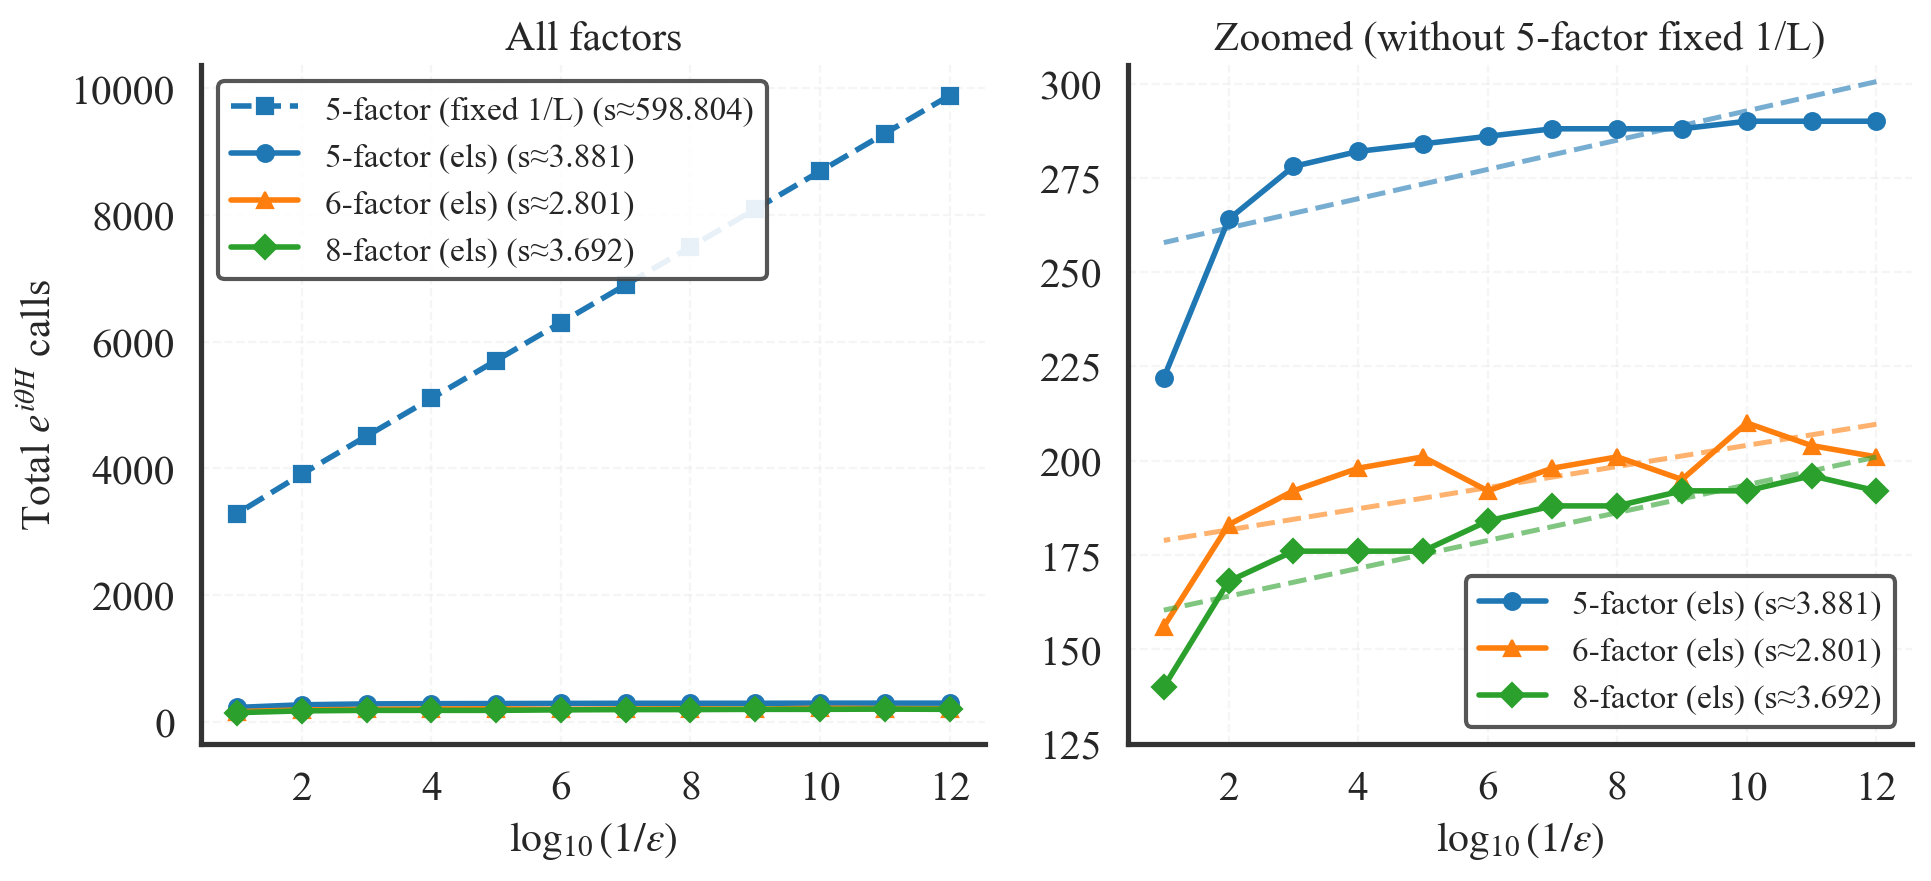

5-factor (fixed 1/L): slope=598.8042, intercept=2704.2727
5-factor (els): slope=3.8811, intercept=253.9394
6-factor (els): slope=2.8007, intercept=176.0455
8-factor (els): slope=3.6923, intercept=156.6667


In [32]:
# --- config: 5-factor family as before ---
delta = np.pi
def M_mat_5_family(t, x, y, q0):
    return M_mat_5_family_factor(t, x, y, q0, delta)

# experiment config (choose n_fixed so runtime is reasonable)
n_fixed = 15      # adjust smaller/larger for speed/accuracy
M = 1
N = 2**n_fixed

tol_values = np.logspace(-12, -1, 12)   # scan tolerances
T_cap = 5000                            # maximum iterations per run

# --- 4 methods, with K_num_H = number of H-calls per iteration ---
methods = [
    ("5-factor (fixed 1/L)", M_mat_5_family, "fixed", 2),
    ("5-factor (els)",       M_mat_5_family, "els",   2),
    ("6-factor (els)",       M_mat_6_family, "els",   3),
    ("8-factor (els)",       M_mat_8_factor, "els",   4),
]

# 存储“迭代次数”：每种方法对应 tol_values 的迭代次数
iters_by_method = {name: [] for name, *_ in methods}

for tol in tol_values:
    for name, M_mat_fun, step_method, _ in methods:
        q_list = run_once(n_fixed, M_mat_fun, M, T_cap, tol, step=step_method)
        last_t = len(q_list) - 1
        iters_by_method[name].append(last_t)
    print(
        f"tol={tol:.1e} -> "
        + ", ".join([f"{name}:{iters_by_method[name][-1]}" for name, *_ in methods])
    )

# --- x 轴：log10(1/tol) ---
x = np.log10(1.0 / tol_values)

# --- 把结果整理成和 size-scaling 版本类似的结构，并基于 total H calls 做线性拟合 ---
results = {}
for name, _, _, K_num_H in methods:
    iters = np.array(iters_by_method[name], dtype=float)
    results[name] = {
        "iters": iters,
        "K_num_H": K_num_H,
    }

slopes = {}
intercepts = {}   # 新增：保存截距
for name, _, _, _ in methods:
    iters = results[name]["iters"]
    K_num_H = results[name]["K_num_H"]
    total_H_calls = K_num_H * iters
    slope, intercept = np.polyfit(x, total_H_calls, 1)
    slopes[name] = slope
    intercepts[name] = intercept   # 新增

# --- 绘图：左边 4 条曲线，右边 zoom（仅 3 条 els） ---
from matplotlib.ticker import MaxNLocator

fig, (ax_all, ax_zoom) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

colors     = ['#1f77b4', '#1f77b4', '#ff7f0e', '#2ca02c']
markers    = ['s',        'o',        '^',        'D']
linestyles = ['--',       '-',       '-',        '-']

# ---------------- 左图：4 条曲线全部画在一起，并在 legend 中标出斜率 ----------------
for (name, _, _, _), color, marker, linestyle in zip(methods, colors, markers, linestyles):
    iters = results[name]["iters"]
    K_num_H = results[name]["K_num_H"]
    total_H_calls = K_num_H * iters

    slope = slopes[name]
    label = f"{name} (s≈{slope:.3f})"

    ax_all.plot(
        x, total_H_calls,
        marker=marker, linewidth=2,
        label=label, color=color,
        markersize=6, linestyle=linestyle,
    )

ax_all.set_xlabel(r'$\log_{10}(1/\varepsilon)$')
ax_all.set_ylabel(r"Total $e^{i\theta H}$ calls")
ax_all.set_title(r"All factors")
ax_all.grid(True, linestyle='--', alpha=0.4)
ax_all.legend(loc='best')   # 调整图例位置
ax_all.xaxis.set_major_locator(MaxNLocator(integer=True))

# ---------------- 右图：只画 3 条（去掉 5-factor fixed），并放大 y 轴 ----------------
zoom_y_min = float('inf')
zoom_y_max = float('-inf')

for (name, _, _, _), color, marker, linestyle in zip(methods, colors, markers, linestyles):
    if name == "5-factor (fixed 1/L)":
        continue  # 右图不画 fixed 版本

    iters = results[name]["iters"]
    K_num_H = results[name]["K_num_H"]
    total_H_calls = K_num_H * iters

    slope = slopes[name]
    intercept = intercepts[name]
    label = f"{name} (s≈{slope:.3f})"

    # 实际数据
    ax_zoom.plot(
        x, total_H_calls,
        marker=marker, linewidth=2,
        label=label, color=color,
        markersize=6, linestyle=linestyle,
    )

    # 拟合直线（虚线）
    y_fit = slope * x + intercept
    ax_zoom.plot(
        x, y_fit,
        linestyle='--',
        color=color,
        alpha=0.6,
    )

    zoom_y_min = min(zoom_y_min, total_H_calls.min())
    zoom_y_max = max(zoom_y_max, total_H_calls.max())

ax_zoom.set_xlabel(r'$\log_{10}(1/\varepsilon)$')
ax_zoom.set_title(r"Zoomed (without 5-factor fixed 1/L)")
ax_zoom.grid(True, linestyle='--', alpha=0.4)
ax_zoom.legend(loc='best')   # 调整图例位置
ax_zoom.xaxis.set_major_locator(MaxNLocator(integer=True))

# 给右图一点上下 margin
if zoom_y_max > zoom_y_min:
    margin = 0.1 * (zoom_y_max - zoom_y_min)
else:
    margin = 1.0
ax_zoom.set_ylim(zoom_y_min - margin, zoom_y_max + margin)

fig.tight_layout(rect=[0, 0, 1, 0.95]) # type: ignore
fig.savefig("H_calls_vs_tol_4methods.png")
plt.show()

# 简要打印各条“总 H 调用数 vs log10(1/tol)”的拟合斜率
for name, _, _, _ in methods:
    iters = results[name]["iters"]
    K_num_H = results[name]["K_num_H"]
    total_H_calls = K_num_H * iters
    co = np.polyfit(x, total_H_calls, 1)
    print(f"{name}: slope={co[0]:.4f}, intercept={co[1]:.4f}")
